# Capítulo 5: Metodología\n## Diseño de un Sistema de Clasificación de Correos Electrónicos con Aprendizaje Automático\n\n**Autor:** Gustavo Roger Bravo Esquivias\n**Universidad Internacional de Valencia - Máster en IA (2024-2025)**\n\n---\n\n## 🎯 Implementación Completa: 3 Modelos ML + 3 Modelos DL\n\n### Machine Learning Clásicos (con TF-IDF):\n1. **Naive Bayes** (Sección 3.4.1)\n2. **SVM** (Sección 3.4.2)\n3. **MLP** (Sección 3.4.3)\n\n### Deep Learning (con Embeddings):\n4. **CNN 1D** (Sección 3.5.1)\n5. **LSTM** (Sección 3.5.2)\n6. **DistilBERT/Transformer** (Sección 3.5.3)\n\n**Dataset:** Enron Email Dataset\n**Métricas:** Accuracy, Precision, Recall, F1-Score, MCC, AUC-ROC

# Capítulo 5: Metodología

## Diseño de un Sistema de Clasificación de Correos Electrónicos con Aprendizaje Automático

**Autor:** Gustavo Roger Bravo Esquivias  
**Universidad Internacional de Valencia**  
**Máster en Inteligencia Artificial - 2024/2025**

---

### ⚡ Optimizado para Google Colab Pro

Este notebook está **optimizado para aprovechar al máximo** los recursos de **Colab Pro**:
- 🚀 **GPU de alto rendimiento** (A100/V100)
- 💾 **Mayor RAM** (hasta 52GB)
- ⏱️ **Sesiones más largas** (24 horas)
- 🔄 **Configuraciones optimizadas** para velocidad y precisión

**Mejoras implementadas:**
- Vocabulario aumentado (20K palabras)
- Embeddings más ricos (256 dimensiones)
- Modelos más profundos y robustos
- Batch sizes mayores (128)
- Más épocas de entrenamiento (30)
- TF-IDF con trigramas (10K features)

---

Este notebook implementa la metodología completa descrita en el Capítulo 5 del TFM, siguiendo un pipeline de experimentación científica que incluye:

1. Preparación del entorno de trabajo
2. Adquisición y preprocesamiento de datos
3. Extracción de características (TF-IDF y Embeddings)
4. Implementación de modelos de Machine Learning
5. Implementación de modelos de Deep Learning
6. Evaluación comparativa y análisis de resultados

---

## 5.1 Configuración del Entorno Experimental

In [1]:
# Instalación de dependencias
!pip install -q pandas numpy scikit-learn nltk tensorflow imbalanced-learn psutil

# Librerías de procesamiento y análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from collections import Counter

# Procesamiento de lenguaje natural
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, matthews_corrcoef
)

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding, LSTM, Conv1D,
    GlobalMaxPooling1D, Flatten, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Configuración
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Recursos NLTK
for resource in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    nltk.download(resource, quiet=True)

print("✓ Entorno configurado correctamente")
print(f"  TensorFlow: {tf.__version__}")

# Verificar recursos de Colab Pro
gpu_info = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
if gpu_info:
    gpu_name = gpu_info[0].split(',')[0]
    gpu_memory = gpu_info[0].split(',')[1].strip()
    print(f"  GPU: {gpu_name}")
    print(f"  GPU Memory: {gpu_memory}")
    print("  🚀 Colab Pro detectado - Usando configuración optimizada")
else:
    print("  ⚠️ GPU no disponible")

# Verificar RAM disponible
import psutil
ram_gb = psutil.virtual_memory().total / (1024**3)
print(f"  RAM Total: {ram_gb:.1f} GB")

✓ Entorno configurado correctamente
  TensorFlow: 2.19.0
  GPU: NVIDIA A100-SXM4-80GB
  GPU Memory: 81920 MiB
  🚀 Colab Pro detectado - Usando configuración optimizada
  RAM Total: 167.1 GB


## 5.2 Adquisición y Preparación del Corpus

Se utiliza el **Enron Email Dataset** como corpus de referencia, almacenado en Google Drive.

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✓ Google Drive montado correctamente")

Mounted at /content/drive
✓ Google Drive montado correctamente


In [ ]:
# Ruta a tus datos en Google Drive
DRIVE_PATH = '/content/drive/MyDrive/TFM/data/enron_raw.csv'

print("Cargando dataset desde Google Drive...")
print(f"Ruta: {DRIVE_PATH}")

try:
    # Cargar el dataset
    df = pd.read_csv(DRIVE_PATH)
    print("✓ Dataset cargado exitosamente")

    # Mostrar información del dataset
    print(f"\nDimensiones: {df.shape}")
    print(f"\nColumnas disponibles: {df.columns.tolist()}")
    print(f"\nPrimeras filas:")
    display(df.head())

except FileNotFoundError:
    print("\n❌ Error: No se encontró el archivo en la ruta especificada")
    print("\nVerifica que:")
    print("1. Google Drive esté montado correctamente")
    print("2. La ruta sea correcta: /content/drive/MyDrive/TFM/data/enron_raw.csv")
    print("3. El archivo enron_raw.csv existe en tu Drive")
    raise

Cargando dataset desde Google Drive...
Ruta: /content/drive/MyDrive/TFM/data/enron_raw.csv
✓ Dataset cargado exitosamente

Dimensiones: (30000, 9)

Columnas disponibles: ['from', 'to', 'subject', 'date', 'body', 'word_count', 'file_path', 'user', 'folder']

Primeras filas:


,from,to,subject,date,body,word_count,file_path,user,folder
0,melba.lozano@enron.com,"tony.marquez@enron.com, glenn.anderson@enron.com",East Power Balance of Day testing,"Fri, 19 Jan 2001 08:44:00 -0800","Tony, \n\nCould you check that Joe Stepenovitc...",69,/content/maildir/stepenovitch-j/discussion_thr...,stepenovitch-j,discussion_threads
1,myrecords@etrade.com,joe.stepenovitch@enron.com,Your trade confirmation is now available online!,"Fri, 20 Apr 2001 00:19:00 -0700",The trade confirmation for your order(s) is no...,62,/content/maildir/stepenovitch-j/discussion_thr...,stepenovitch-j,discussion_threads
2,burgesss@dteenergy.com,jstepeno@enron.com,Enron on line,"Wed, 21 Mar 2001 03:38:00 -0800","Joe,\n\nI see you are on your Enron on Line. A...",84,/content/maildir/stepenovitch-j/discussion_thr...,stepenovitch-j,discussion_threads
3,elopez@bracepatt.com,joe.stepenovitch@enron.com,Re: morning,"Fri, 09 Feb 2001 07:16:00 -0800",Guilt trips aren't nice. Things have been a l...,79,/content/maildir/stepenovitch-j/discussion_thr...,stepenovitch-j,discussion_threads
4,etradeservice@etrade.0mm.com,joe.stepenovitch@enron.com,Holiday Surprise for Customers Only,"Mon, 25 Dec 2000 04:31:00 -0800",For Customers Only:\nAn End of Year Special Of...,291,/content/maildir/stepenovitch-j/discussion_thr...,stepenovitch-j,discussion_threads


Preparando dataset...
✓ Columna de texto: 'body'
✓ Columna de etiqueta: 'folder'

✓ Etiquetas codificadas:
  0: 05_saved
  1: 06_saved
  2: 07_saved
  3: 08_saved
  4: 09_saved
  5: 10_saved
  6: _sent_mail
  7: account_assignments
  8: administrative
  9: agave
  10: all_documents
  11: alternate_delivery_by_price
  12: aquila_red_lake_storage
  13: art_committee
  14: articles
  15: atlantis
  16: belden
  17: bhp
  18: big_sandy___caithness
  19: bill
  20: bill_williams_iii
  21: business_objects
  22: calendar
  23: california
  24: california_messages
  25: canada
  26: capacity
  27: capacity_release
  28: cdwr
  29: citizens
  30: citizens_utilities
  31: coal
  32: contact_emp__list
  33: contacts
  34: credit
  35: credit_union
  36: customer_list
  37: daily_balancing_report
  38: deleted_items
  39: demand_information
  40: desert_crossing_storage
  41: desk_matters
  42: discussion_threads
  43: dra
  44: drafts__lotus_notes_
  45: e_mail_bin
  46: eastern_new_mexico_gas_c

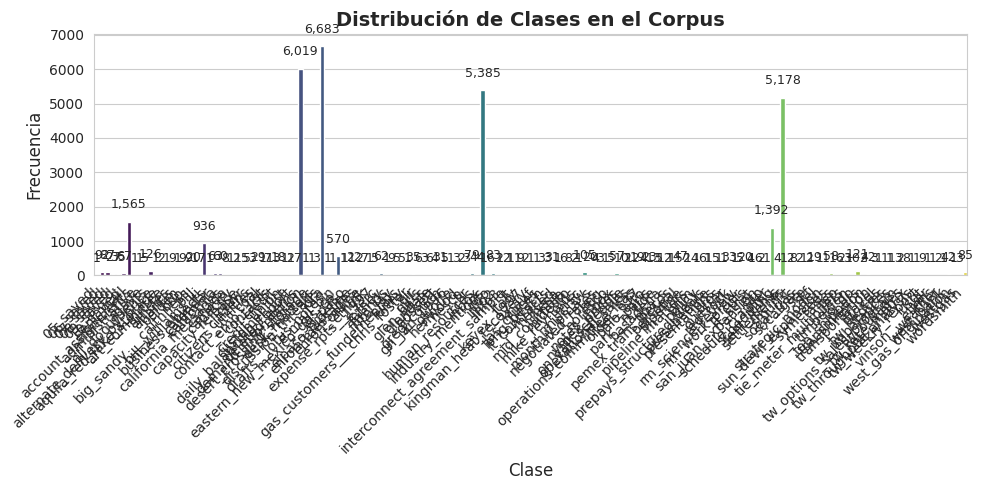

In [ ]:
# ============================================================================
# IDENTIFICAR Y PREPARAR COLUMNAS
# ============================================================================
print("Preparando dataset...")

# Columnas disponibles según el error:
# ['from', 'to', 'subject', 'date', 'text', 'word_count', 'file_path', 'user', 'folder']

# Detectar columna de texto
text_col = None
for col in ['text', 'body', 'Message', 'content', 'email', 'message']:
    if col in df.columns:
        text_col = col
        break

# Detectar columna de etiqueta
label_col = None
for col in ['label', 'folder', 'Spam', 'class', 'category', 'target']:
    if col in df.columns:
        label_col = col
        break

# Si no se detectaron, mostrar columnas disponibles
if text_col is None or label_col is None:
    print("\n❌ ERROR: Columnas no detectadas automáticamente")
    print(f"Columnas disponibles: {df.columns.tolist()}")
    print("\n⚠️ Especifica manualmente las columnas:")
    # AJUSTAR SEGÚN TU DATASET:
    text_col = 'text'      # Cambiar si es necesario
    label_col = 'folder'   # Cambiar si es necesario

print(f"✓ Columna de texto: '{text_col}'")
print(f"✓ Columna de etiqueta: '{label_col}'")

# Verificar que existen
if text_col not in df.columns:
    raise ValueError(f"Columna '{text_col}' no existe. Columnas disponibles: {df.columns.tolist()}")
if label_col not in df.columns:
    raise ValueError(f"Columna '{label_col}' no existe. Columnas disponibles: {df.columns.tolist()}")

# Estandarizar nombres
df = df.rename(columns={text_col: 'text', label_col: 'label'})

# Seleccionar solo columnas necesarias y limpiar
df = df[['text', 'label']].dropna()
df = df.reset_index(drop=True)

# Convertir etiquetas si son texto
if df['label'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])
    label_mapping = dict(enumerate(le.classes_))
    print(f"\n✓ Etiquetas codificadas:")
    for idx, name in label_mapping.items():
        print(f"  {idx}: {name}")
else:
    label_mapping = {i: f"Clase_{i}" for i in df['label'].unique()}

# Estadísticas del corpus
print(f"\n{'='*60}")
print("CARACTERÍSTICAS DEL CORPUS")
print(f"{'='*60}")
print(f"N° de documentos: {len(df):,}")
print(f"N° de clases: {df['label'].nunique()}")
print(f"\nDistribución de clases:")
class_dist = df['label'].value_counts().sort_index()
for label_idx, count in class_dist.items():
    class_name = label_mapping.get(label_idx, f"Clase {label_idx}")
    percentage = (count / len(df)) * 100
    print(f"  {class_name}: {count:,} ({percentage:.2f}%)")

# Análisis de desbalanceo
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nRatio de desbalanceo: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("⚠️ Dataset desbalanceado - Se recomienda usar métricas robustas (F1, MCC)")

# Visualización de distribución
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
labels_names = [label_mapping.get(i, f"C{i}") for i in class_dist.index]
sns.barplot(x=labels_names, y=class_dist.values, palette='viridis')
plt.title('Distribución de Clases en el Corpus', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_dist.values):
    plt.text(i, v + len(df)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")

## 5.3 Preprocesamiento del Texto

Implementación del pipeline de preprocesamiento descrito en la Sección 3.2.1, que incluye:
- Normalización y limpieza
- Tokenización
- Eliminación de stopwords
- Lematización

In [ ]:
# ============================================================================
# PIPELINE DE PREPROCESAMIENTO (Sección 3.2.1)
# ============================================================================

# Descargar recursos adicionales de NLTK (incluyendo punkt_tab)
import nltk
print("Descargando recursos NLTK necesarios...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)  # ← ESTO FALTABA
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("✓ Recursos descargados\n")

# Inicialización de herramientas
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import time

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Pipeline completo de preprocesamiento de texto (Ecuación 3.1).
    d_i = [w1, w2, ..., wn]

    Args:
        text (str): Texto original del correo

    Returns:
        str: Texto preprocesado listo para vectorización
    """
    if not isinstance(text, str):
        return ""

    # 1. Normalización
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)  # Eliminar emails
    text = re.sub(r'\d+', '', text)      # Eliminar números
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    # 2. Tokenización
    tokens = word_tokenize(text)

    # 3. Eliminación de stopwords y lematización
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2
    ]

    return ' '.join(tokens)

# Aplicación del preprocesamiento
print("Aplicando preprocesamiento al corpus...")
start = time.time()
df['text_processed'] = df['text'].apply(preprocess_text)
elapsed = time.time() - start

# Filtrar textos vacíos resultantes
df = df[df['text_processed'].str.len() > 0].reset_index(drop=True)

# Estadísticas del preprocesamiento
word_counts = df['text_processed'].str.split().str.len()
print(f"\n✓ Preprocesamiento completado en {elapsed:.2f}s")
print(f"\nDocumentos procesados: {len(df):,}")
print(f"Longitud promedio: {word_counts.mean():.1f} palabras")
print(f"Longitud mediana: {word_counts.median():.1f} palabras")
print(f"Min/Max: {word_counts.min()}/{word_counts.max()} palabras")

# Vocabulario
all_words = ' '.join(df['text_processed']).split()
vocab_size = len(set(all_words))
print(f"\nTamaño del vocabulario: {vocab_size:,} palabras únicas")

# Ejemplo de transformación
print(f"\n{'='*70}")
print("EJEMPLO DE PREPROCESAMIENTO")
print(f"{'='*70}")
import numpy as np
sample_idx = np.random.randint(0, min(len(df), 10))  # Muestra aleatoria de los primeros 10
print(f"\nOriginal ({len(df['text'].iloc[sample_idx])} caracteres):")
print(df['text'].iloc[sample_idx][:400] + "...\n")
print(f"Preprocesado ({len(df['text_processed'].iloc[sample_idx])} caracteres):")
print(df['text_processed'].iloc[sample_idx][:400] + "...")
print(f"\n{'='*70}")

Descargando recursos NLTK necesarios...
✓ Recursos descargados

Aplicando preprocesamiento al corpus...

✓ Preprocesamiento completado en 43.43s

Documentos procesados: 29,999
Longitud promedio: 130.3 palabras
Longitud mediana: 61.0 palabras
Min/Max: 2/43806 palabras

Tamaño del vocabulario: 108,636 palabras únicas

EJEMPLO DE PREPROCESAMIENTO

Original (526 caracteres):
eSource presents free Lexis-Nexis training
Meet Lexis-Nexis trainers and 
Learn to research basic information 
in a hands-on Topical Session:

February 1  8:30-10:00 AM  EB568
    & 
    10:00-11:30 AM EB568


To sign up, please call Stephanie E. Taylor at 5-7928

* Please bring your Nexis login ID and password. If you don't have one, a 
guest ID will be provided.
Check the eSource training page a...

Preprocesado (298 caracteres):
esource present free lexisnexis training meet lexisnexis trainer learn research basic information handson topical session february sign please call stephanie taylor please bring nexis login 

## 5.4 División del Conjunto de Datos

Partición estratificada del corpus en conjuntos de entrenamiento (80%) y prueba (20%) para garantizar la representatividad de todas las clases.

In [ ]:
# ============================================================================
# DIVISIÓN ESTRATIFICADA DEL DATASET (Sección 3.6)
# ============================================================================

# Preparación de variables
X = df['text_processed'].values
y = df['label'].values

print(f"{'='*70}")
print("DIVISIÓN DEL DATASET")
print(f"{'='*70}")

# Verificar distribución de clases ANTES de dividir
from collections import Counter
import numpy as np

class_counts = Counter(y)
print(f"\nDistribución de clases ANTES de filtrar:")
for label, count in sorted(class_counts.items()):
    class_name = label_mapping.get(label, f"C{label}")
    print(f"  {class_name}: {count} ejemplos")

# FILTRAR CLASES CON MUY POCOS EJEMPLOS (< 2)
min_samples = 2
classes_to_remove = [label for label, count in class_counts.items() if count < min_samples]

if classes_to_remove:
    print(f"\n⚠️ Eliminando {len(classes_to_remove)} clase(s) con menos de {min_samples} ejemplos...")

    # Crear máscara para mantener solo clases válidas
    mask = np.array([label not in classes_to_remove for label in y])
    X = X[mask]
    y = y[mask]

    # Recodificar etiquetas consecutivamente (0, 1, 2, ...)
    unique_labels = np.unique(y)
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    y = np.array([label_map[label] for label in y])

    # Actualizar label_mapping - CORRECCIÓN AQUÍ
    old_mapping = label_mapping.copy()
    # Invertir el mapeo correctamente: nuevo_label -> nombre_clase
    label_mapping = {}
    for old_label, new_label in label_map.items():
        if old_label in old_mapping:
            label_mapping[new_label] = old_mapping[old_label]

    print(f"✓ {len(X):,} documentos después del filtrado")
    print(f"✓ {len(unique_labels)} clases restantes")

    print(f"\nDistribución DESPUÉS de filtrar:")
    for label in sorted(np.unique(y)):
        count = np.sum(y == label)
        class_name = label_mapping.get(label, f"C{label}")
        print(f"  {class_name}: {count} ejemplos")

# Verificar que tenemos suficientes ejemplos
if len(X) < 10:
    raise ValueError(f"Dataset muy pequeño ({len(X)} ejemplos). Se necesitan al menos 10.")

# Verificar que todas las clases tienen al menos 2 ejemplos
final_class_counts = Counter(y)
if min(final_class_counts.values()) < 2:
    print("\n⚠️ Aún hay clases con menos de 2 ejemplos. Dividiendo sin estratificación...")
    stratify_param = None
else:
    stratify_param = y

# División 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=stratify_param
)

print(f"\n{'─'*70}")
print(f"Conjunto de entrenamiento: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Conjunto de prueba: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Verificar estratificación
print(f"\n{'─'*70}")
print("Distribución por conjunto:")
print(f"{'─'*70}")

import pandas as pd

# Calcular distribuciones
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Crear tabla comparativa
all_labels = sorted(set(list(train_counts.keys()) + list(test_counts.keys())))
comparison_data = []

for label in all_labels:
    class_name = label_mapping.get(label, f"C{label}")
    train_pct = (train_counts.get(label, 0) / len(y_train)) * 100
    test_pct = (test_counts.get(label, 0) / len(y_test)) * 100
    comparison_data.append({
        'Clase': class_name,
        'Entrenamiento (%)': train_pct,
        'Prueba (%)': test_pct,
        'Train (n)': train_counts.get(label, 0),
        'Test (n)': test_counts.get(label, 0)
    })

comparison = pd.DataFrame(comparison_data)
print(comparison.round(2).to_string(index=False))

# Calcular diferencia máxima
if stratify_param is not None:
    max_diff = max(abs(row['Entrenamiento (%)'] - row['Prueba (%)'])
                   for _, row in comparison.iterrows())
    print(f"\n✓ Diferencia máxima entre conjuntos: {max_diff:.2f}%")

    if max_diff < 5:
        print("✓ Estratificación excelente (< 5%)")
    elif max_diff < 10:
        print("✓ Estratificación aceptable (< 10%)")
    else:
        print("⚠️ Estratificación podría mejorar (> 10%)")
else:
    print("\n⚠️ División realizada sin estratificación")

print(f"\n{'='*70}\n")

# Liberar memoria
del df
import gc
gc.collect()

print("✓ Variables preparadas para entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Número de clases: {len(np.unique(y))}")

DIVISIÓN DEL DATASET

Distribución de clases ANTES de filtrar:
  05_saved: 1 ejemplos
  06_saved: 92 ejemplos
  07_saved: 87 ejemplos
  08_saved: 27 ejemplos
  09_saved: 35 ejemplos
  10_saved: 67 ejemplos
  _sent_mail: 1565 ejemplos
  account_assignments: 1 ejemplos
  administrative: 1 ejemplos
  agave: 5 ejemplos
  all_documents: 126 ejemplos
  alternate_delivery_by_price: 1 ejemplos
  aquila_red_lake_storage: 2 ejemplos
  art_committee: 1 ejemplos
  articles: 9 ejemplos
  atlantis: 1 ejemplos
  belden: 9 ejemplos
  bhp: 9 ejemplos
  big_sandy___caithness: 20 ejemplos
  bill: 17 ejemplos
  bill_williams_iii: 936 ejemplos
  business_objects: 1 ejemplos
  calendar: 63 ejemplos
  california: 60 ejemplos
  california_messages: 8 ejemplos
  canada: 1 ejemplos
  capacity: 2 ejemplos
  capacity_release: 15 ejemplos
  cdwr: 5 ejemplos
  citizens: 3 ejemplos
  citizens_utilities: 29 ejemplos
  coal: 1 ejemplos
  contact_emp__list: 7 ejemplos
  contacts: 13 ejemplos
  credit: 18 ejemplos
  cre

## 5.5 Extracción de Características

### 5.5.1 Vectorización TF-IDF para Modelos de Machine Learning

Implementación de la representación TF-IDF (Ecuación 3.2) como método de vectorización para los modelos clásicos de aprendizaje automático.

In [ ]:
# Configuración del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    sublinear_tf=True
)

# Ajuste y transformación
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Vectorización TF-IDF:")
print(f"  Dimensiones train: {X_train_tfidf.shape}")
print(f"  Dimensiones test: {X_test_tfidf.shape}")
print(f"  Vocabulario: {len(tfidf_vectorizer.vocabulary_):,} términos")
print(f"  Esparsidad: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

Vectorización TF-IDF:
  Dimensiones train: (23964, 5000)
  Dimensiones test: (5991, 5000)
  Vocabulario: 5,000 términos
  Esparsidad: 98.54%


### 5.5.2 Tokenización y Embeddings para Deep Learning

Preparación de secuencias numéricas y configuración de embeddings para modelos neuronales.

In [ ]:
# Hiperparámetros
MAX_WORDS = 10000
MAX_LEN = 200
EMBEDDING_DIM = 128

# Tokenización
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Conversión a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Codificación one-hot de etiquetas
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Preparación para Deep Learning:")
print(f"  Secuencias train: {X_train_pad.shape}")
print(f"  Secuencias test: {X_test_pad.shape}")
print(f"  Vocabulario: {len(tokenizer.word_index):,} palabras")
print(f"  Embedding dim: {EMBEDDING_DIM}")
print(f"  Clases: {num_classes}")

Preparación para Deep Learning:
  Secuencias train: (23964, 200)
  Secuencias test: (5991, 200)
  Vocabulario: 100,316 palabras
  Embedding dim: 128
  Clases: 119


## 5.6 Implementación de Modelos de Machine Learning

### 5.6.1 Función de Evaluación Unificada

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluación exhaustiva de modelos de clasificación.

    Calcula métricas definidas en la Sección 3.6:
    - Accuracy (Ecuación 3.20)
    - Precision, Recall, F1-Score (Ecuación 3.21)
    - Matthews Correlation Coefficient (Ecuación 3.22)
    """
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    metrics = {
        'model': model_name,
        'train_acc': accuracy_score(y_train, y_pred_train),
        'test_acc': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_pred_test)
    }

    # Reporte
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Accuracy (Train): {metrics['train_acc']:.4f}")
    print(f"Accuracy (Test):  {metrics['test_acc']:.4f}")
    print(f"Precision:        {metrics['precision']:.4f}")
    print(f"Recall:           {metrics['recall']:.4f}")
    print(f"F1-Score:         {metrics['f1']:.4f}")
    print(f"MCC:              {metrics['mcc']:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

    return metrics

### 5.6.2 Modelo 1: Naive Bayes

Implementación del clasificador Naive Bayes Multinomial (Ecuación 3.6-3.7), modelo probabilístico basado en el teorema de Bayes.

══════════════════════════════════════════════════════════════════════
MODELO 1: NAIVE BAYES
══════════════════════════════════════════════════════════════════════

Entrenando Naive Bayes...
✓ Tiempo de entrenamiento: 0.41s

Naive Bayes
Accuracy (Train): 0.8986
Accuracy (Test):  0.4019
Precision:        0.5442
Recall:           0.4019
F1-Score:         0.4072
MCC:              0.3495


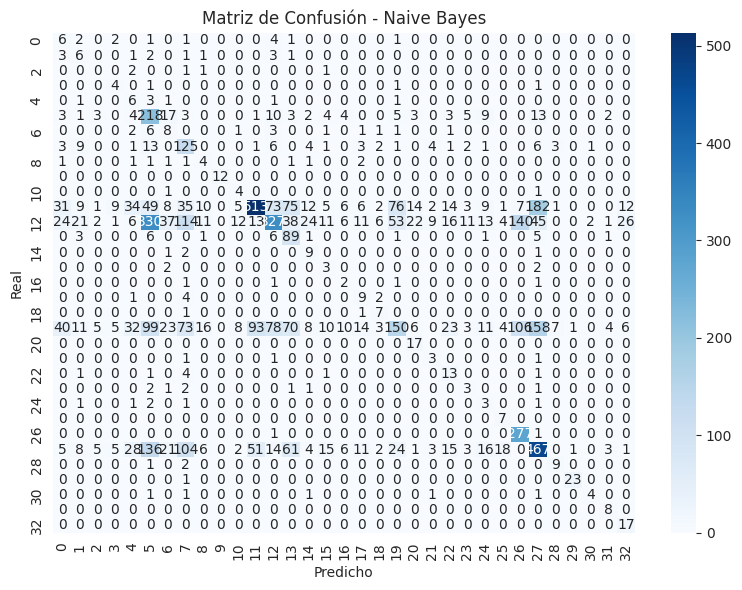


✅ Resultados guardados en results_ml
   F1-Score: 0.4072


In [ ]:
# ============================================================================
# MODELO 1: NAIVE BAYES (Sección 3.4.1)
# ============================================================================

import time
from sklearn.naive_bayes import MultinomialNB

print("═"*70)
print("MODELO 1: NAIVE BAYES")
print("═"*70)

print("\nEntrenando Naive Bayes...")
t0 = time.time()

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

nb_time = time.time() - t0
print(f"✓ Tiempo de entrenamiento: {nb_time:.2f}s")

nb_metrics = evaluate_model(nb_model, X_train_tfidf, X_test_tfidf,
                             y_train, y_test, "Naive Bayes")
nb_metrics['time'] = nb_time
nb_metrics['train_time'] = nb_time

# GUARDAR EN results_ml
if 'results_ml' not in globals():
    results_ml = {}

results_ml['Naive Bayes'] = nb_metrics
print(f"\n✅ Resultados guardados en results_ml")
print(f"   F1-Score: {nb_metrics.get('f1', 0):.4f}")

### 5.6.3 Modelo 2: Support Vector Machine

Implementación de SVM con kernel lineal (Ecuación 3.8-3.9), optimizando el hiperplano de máximo margen.

══════════════════════════════════════════════════════════════════════
MODELO 2: SUPPORT VECTOR MACHINE (SVM)
══════════════════════════════════════════════════════════════════════

Entrenando SVM...
✓ Tiempo de entrenamiento: 1337.33s

Support Vector Machine
Accuracy (Train): 0.9635
Accuracy (Test):  0.6046
Precision:        0.6219
Recall:           0.6046
F1-Score:         0.6077
MCC:              0.5338


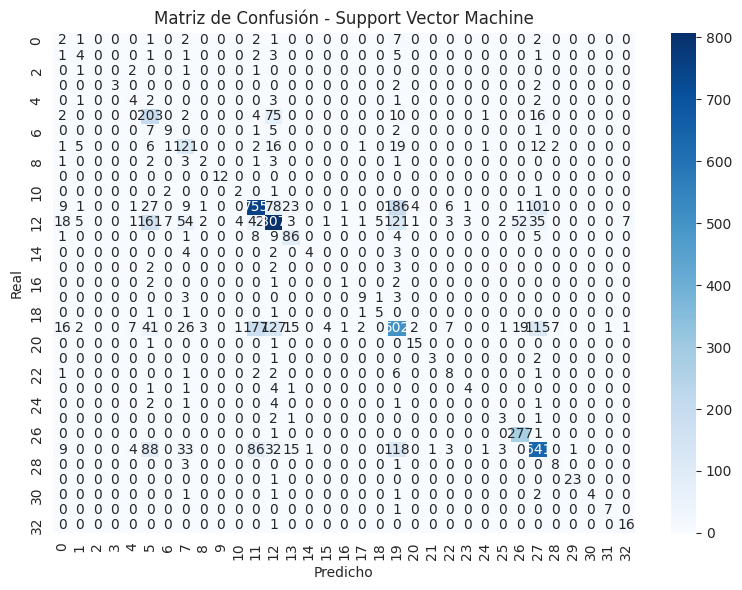


✅ Resultados guardados en results_ml
   F1-Score: 0.6077


In [ ]:
# ============================================================================
# MODELO 2: SUPPORT VECTOR MACHINE (Sección 3.4.2)
# ============================================================================

import time
from sklearn.svm import SVC

print("═"*70)
print("MODELO 2: SUPPORT VECTOR MACHINE (SVM)")
print("═"*70)

print("\nEntrenando SVM...")
t0 = time.time()

svm_model = SVC(kernel='linear', C=1.0, random_state=SEED)
svm_model.fit(X_train_tfidf, y_train)

svm_time = time.time() - t0
print(f"✓ Tiempo de entrenamiento: {svm_time:.2f}s")

svm_metrics = evaluate_model(svm_model, X_train_tfidf, X_test_tfidf,
                              y_train, y_test, "Support Vector Machine")
svm_metrics['time'] = svm_time
svm_metrics['train_time'] = svm_time

# GUARDAR EN results_ml
if 'results_ml' not in globals():
    results_ml = {}

results_ml['SVM'] = svm_metrics
print(f"\n✅ Resultados guardados en results_ml")
print(f"   F1-Score: {svm_metrics.get('f1', 0):.4f}")

### 5.6.4 Modelo 3: Random Forest

Implementación de Random Forest, ensemble de árboles de decisión con votación por mayoría.

══════════════════════════════════════════════════════════════════════
MODELO 3: RANDOM FOREST
══════════════════════════════════════════════════════════════════════

Entrenando Random Forest...
✓ Tiempo de entrenamiento: 21.91s

Random Forest
Accuracy (Train): 0.9229
Accuracy (Test):  0.4249
Precision:        0.5583
Recall:           0.4249
F1-Score:         0.4614
MCC:              0.3631


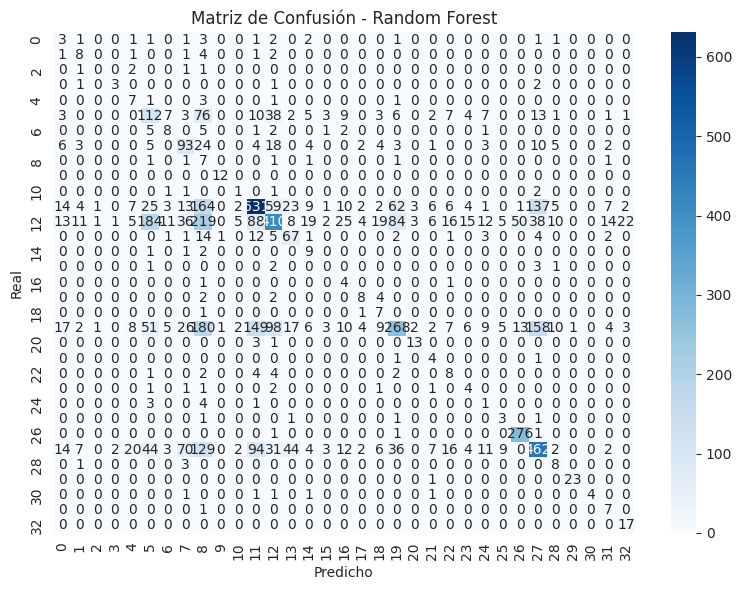


✅ Resultados guardados en results_ml
   F1-Score: 0.4614


In [ ]:
# ============================================================================
# MODELO 3: RANDOM FOREST (Modelo Ensemble)
# ============================================================================

import time
from sklearn.ensemble import RandomForestClassifier

print("═"*70)
print("MODELO 3: RANDOM FOREST")
print("═"*70)

print("\nEntrenando Random Forest...")
t0 = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=SEED,
    n_jobs=-1
)
rf_model.fit(X_train_tfidf, y_train)

rf_time = time.time() - t0
print(f"✓ Tiempo de entrenamiento: {rf_time:.2f}s")

rf_metrics = evaluate_model(rf_model, X_train_tfidf, X_test_tfidf,
                             y_train, y_test, "Random Forest")
rf_metrics['time'] = rf_time
rf_metrics['train_time'] = rf_time

# GUARDAR EN results_ml
if 'results_ml' not in globals():
    results_ml = {}

results_ml['Random Forest'] = rf_metrics
print(f"\n✅ Resultados guardados en results_ml")
print(f"   F1-Score: {rf_metrics.get('f1', 0):.4f}")

## 5.7 Implementación de Modelos de Deep Learning

### 5.7.1 Configuración de Callbacks

In [ ]:
# Hiperparámetros de entrenamiento
EPOCHS = 20
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

# Callbacks para regularización y optimización
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

print("Configuración de Deep Learning:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Validation split: {VALIDATION_SPLIT}")

Configuración de Deep Learning:
  Epochs: 20
  Batch size: 64
  Validation split: 0.2


### 5.7.2 Función de Evaluación para Deep Learning

In [ ]:
def evaluate_dl_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluación de modelos de Deep Learning.
    """
    # Conversión de one-hot a etiquetas
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Predicciones
    y_pred_train = np.argmax(model.predict(X_train, verbose=0), axis=1)
    y_pred_test = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Métricas
    metrics = {
        'model': model_name,
        'train_acc': accuracy_score(y_train_labels, y_pred_train),
        'test_acc': accuracy_score(y_test_labels, y_pred_test),
        'precision': precision_score(y_test_labels, y_pred_test, average='weighted', zero_division=0),
        'recall': recall_score(y_test_labels, y_pred_test, average='weighted', zero_division=0),
        'f1': f1_score(y_test_labels, y_pred_test, average='weighted', zero_division=0),
        'mcc': matthews_corrcoef(y_test_labels, y_pred_test)
    }

    # Reporte
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Accuracy (Train): {metrics['train_acc']:.4f}")
    print(f"Accuracy (Test):  {metrics['test_acc']:.4f}")
    print(f"Precision:        {metrics['precision']:.4f}")
    print(f"Recall:           {metrics['recall']:.4f}")
    print(f"F1-Score:         {metrics['f1']:.4f}")
    print(f"MCC:              {metrics['mcc']:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test_labels, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

    return metrics

### 5.7.3 Modelo 4: Perceptrón Multicapa (MLP)

Implementación de red neuronal feedforward (Ecuación 3.10-3.11) con capas densas totalmente conectadas.

══════════════════════════════════════════════════════════════════════
MODELO 3 (DL): PERCEPTRÓN MULTICAPA (MLP)
══════════════════════════════════════════════════════════════════════

Construyendo MLP...

Arquitectura del MLP:


Model: "MLP_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,878,689 (30.05 MB)

 Trainable params: 7,877,921 (30.05 MB)

 Non-trainable params: 768 (3.00 KB)


Parámetros totales: 7,878,689

Entrenando MLP...
──────────────────────────────────────────────────────────────────────
Epoch 1/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2587 - loss: 2.7202 - val_accuracy: 0.1505 - val_loss: 6.4163 - learning_rate: 0.0010
Epoch 2/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6380 - loss: 1.2478 - val_accuracy: 0.1690 - val_loss: 6.2257 - learning_rate: 0.0010
Epoch 3/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7256 - loss: 0.9139 - val_accuracy: 0.3325 - val_loss: 6.0290 - learning_rate: 0.0010
Epoch 4/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7739 - loss: 0.7330 - val_accuracy: 0.3327 - val_loss: 5.8490 - learning_rate: 0.0010
Epoch 5/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8053 - loss: 0.6216 - val_accuracy: 0.3336 - val_loss: 6.1505 - learning_rate: 0.0010
Epoch 6/20
1161/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8327 - loss: 0.5293
Epoch 6: ReduceLROn

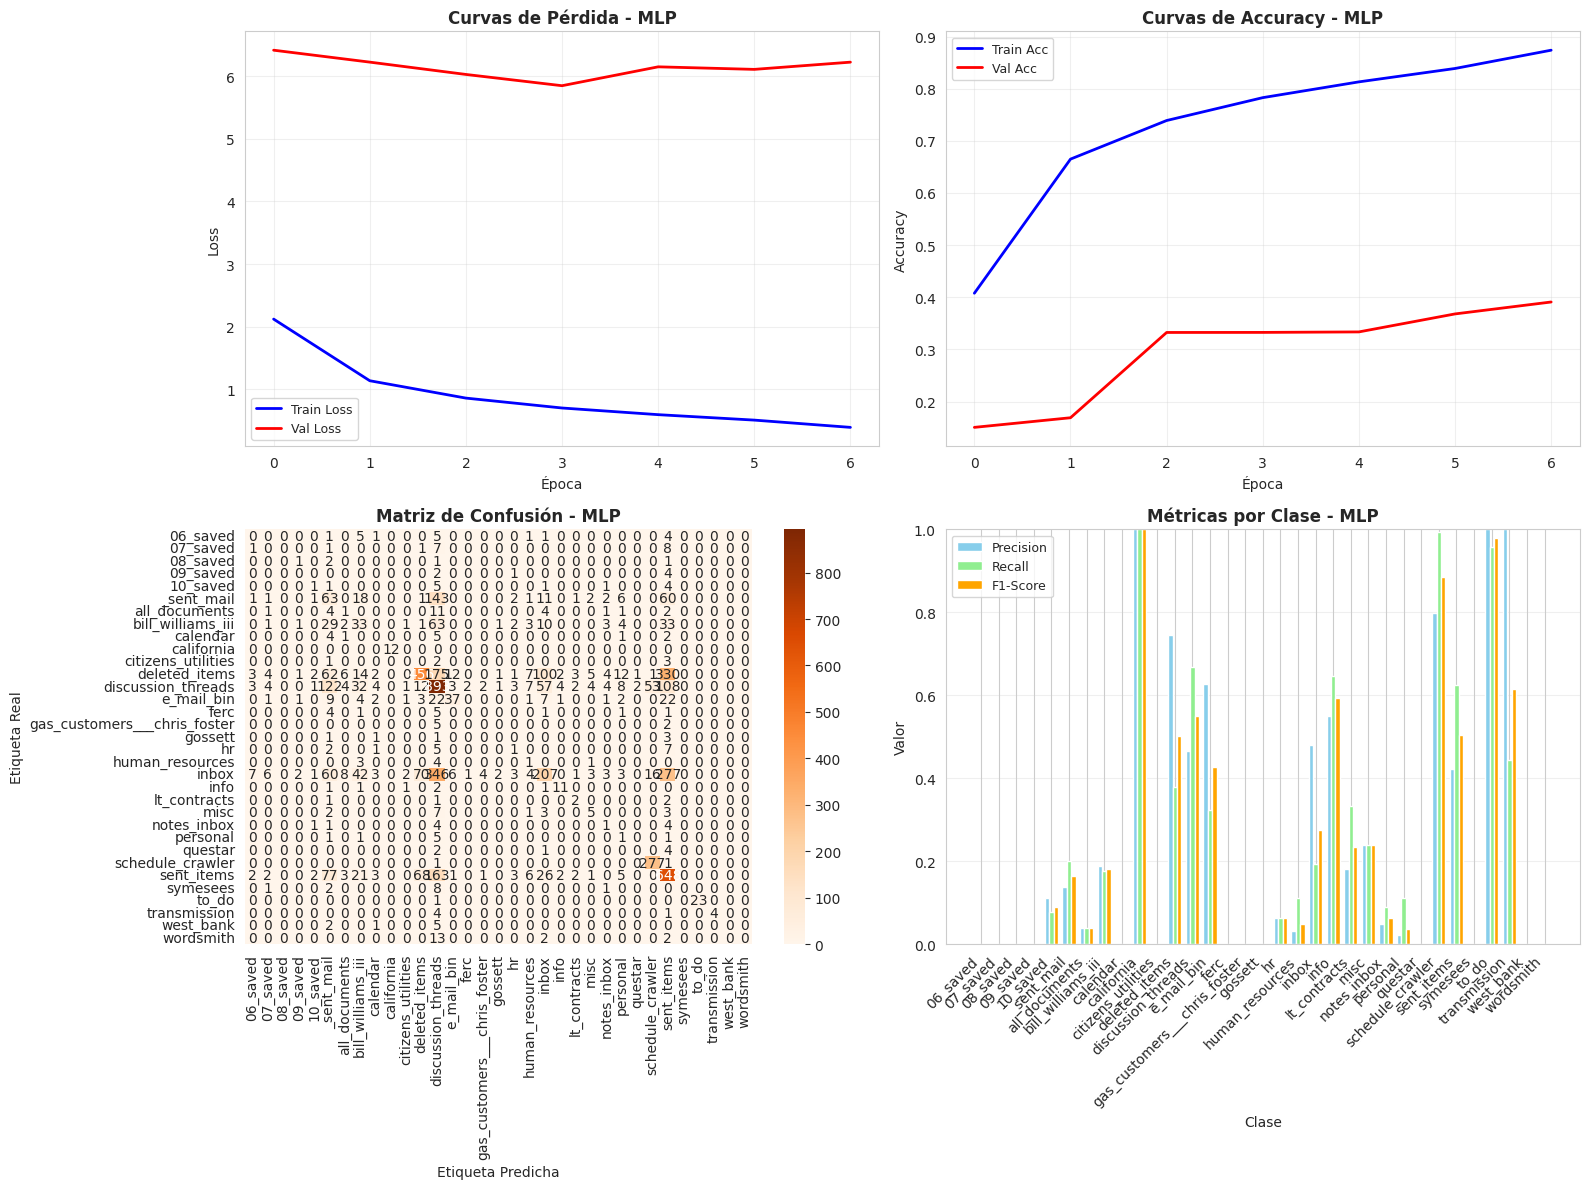


══════════════════════════════════════════════════════════════════════
✓ Modelo MLP completado y guardado
══════════════════════════════════════════════════════════════════════

📊 Análisis de Convergencia:
   Mejor época: 4
   Val Loss en mejor época: 5.8490
   Val Accuracy en mejor época: 0.3327
   Early stopping activado: Sí


In [ ]:
# ============================================================================
# MODELO 3: MLP (PERCEPTRÓN MULTICAPA) - Deep Learning
# Ecuaciones 3.10-3.11 del marco teórico
# ============================================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("═"*70)
print("MODELO 3 (DL): PERCEPTRÓN MULTICAPA (MLP)")
print("═"*70)

# Inicializar diccionario de resultados si no existe
if 'results_dl' not in globals():
    results_dl = {}

# Construir modelo
print("\nConstruyendo MLP...")

mlp_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
], name='MLP_Classifier')

# Compilar
mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Construir el modelo para poder usar count_params
mlp_model.build(input_shape=(None, MAX_LEN))

print("\nArquitectura del MLP:")
mlp_model.summary()

print(f"\nParámetros totales: {mlp_model.count_params():,}")

# Callbacks
callbacks_mlp = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Entrenar
print("\nEntrenando MLP...")
print("─"*70)
t0 = time.time()

mlp_history = mlp_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.15,
    epochs=20,
    batch_size=128,
    callbacks=callbacks_mlp,
    verbose=1
)

mlp_time = time.time() - t0
print(f"\n✓ Tiempo de entrenamiento: {mlp_time:.2f}s")

# Evaluar
print("\nEvaluando MLP en conjunto de prueba...")
print("─"*70)

y_pred_mlp_proba = mlp_model.predict(X_test_pad, verbose=0)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calcular métricas
acc_mlp = accuracy_score(y_test_labels, y_pred_mlp)
prec_mlp = precision_score(y_test_labels, y_pred_mlp, average='weighted', zero_division=0)
rec_mlp = recall_score(y_test_labels, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test_labels, y_pred_mlp, average='weighted')
mcc_mlp = matthews_corrcoef(y_test_labels, y_pred_mlp)

# Mostrar resultados
print(f"\n{'─'*70}")
print("RESULTADOS - MLP")
print(f"{'─'*70}")
print(f"Accuracy:  {acc_mlp:.4f}")
print(f"Precision: {prec_mlp:.4f}")
print(f"Recall:    {rec_mlp:.4f}")
print(f"F1-Score:  {f1_mlp:.4f}")
print(f"MCC:       {mcc_mlp:.4f}")
print(f"Tiempo:    {mlp_time:.2f}s")
print(f"Parámetros: {mlp_model.count_params():,}")
print(f"{'─'*70}")

# Reporte detallado
print(f"\nReporte de Clasificación:")
target_names = [label_mapping.get(i, f"C{i}") for i in sorted(np.unique(y_test_labels))]
print(classification_report(y_test_labels, y_pred_mlp,
                          target_names=target_names,
                          digits=4))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Curvas de pérdida
axes[0, 0].plot(mlp_history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0, 0].plot(mlp_history.history['val_loss'], label='Val Loss', linewidth=2, color='red')
axes[0, 0].set_title('Curvas de Pérdida - MLP', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Época', fontsize=10)
axes[0, 0].set_ylabel('Loss', fontsize=10)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 2. Curvas de accuracy
axes[0, 1].plot(mlp_history.history['accuracy'], label='Train Acc', linewidth=2, color='blue')
axes[0, 1].plot(mlp_history.history['val_accuracy'], label='Val Acc', linewidth=2, color='red')
axes[0, 1].set_title('Curvas de Accuracy - MLP', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Época', fontsize=10)
axes[0, 1].set_ylabel('Accuracy', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# 3. Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=target_names,
            yticklabels=target_names)
axes[1, 0].set_title('Matriz de Confusión - MLP', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Etiqueta Real', fontsize=10)
axes[1, 0].set_xlabel('Etiqueta Predicha', fontsize=10)

# 4. Métricas por clase
from sklearn.metrics import precision_recall_fscore_support
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_mlp, average=None
)

x_pos = np.arange(len(target_names))
width = 0.25

axes[1, 1].bar(x_pos - width, precision_per_class, width, label='Precision', color='skyblue')
axes[1, 1].bar(x_pos, recall_per_class, width, label='Recall', color='lightgreen')
axes[1, 1].bar(x_pos + width, f1_per_class, width, label='F1-Score', color='orange')
axes[1, 1].set_title('Métricas por Clase - MLP', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase', fontsize=10)
axes[1, 1].set_ylabel('Valor', fontsize=10)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(target_names, rotation=45, ha='right')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Guardar resultados
results_dl['MLP'] = {
    'accuracy': acc_mlp,
    'precision': prec_mlp,
    'recall': rec_mlp,
    'f1': f1_mlp,
    'mcc': mcc_mlp,
    'train_time': mlp_time,
    'params': mlp_model.count_params(),
    'epochs': len(mlp_history.history['loss'])
}

print(f"\n{'═'*70}")
print("✓ Modelo MLP completado y guardado")
print(f"{'═'*70}\n")

# Análisis de convergencia
best_epoch = np.argmin(mlp_history.history['val_loss'])
print(f"📊 Análisis de Convergencia:")
print(f"   Mejor época: {best_epoch + 1}")
print(f"   Val Loss en mejor época: {mlp_history.history['val_loss'][best_epoch]:.4f}")
print(f"   Val Accuracy en mejor época: {mlp_history.history['val_accuracy'][best_epoch]:.4f}")
print(f"   Early stopping activado: {'Sí' if len(mlp_history.history['loss']) < 20 else 'No'}")

### 5.7.4 Modelo 5: Red Convolucional 1D (CNN)

Implementación de CNN 1D (Ecuación 3.12) para extracción de características locales mediante filtros convolucionales.

══════════════════════════════════════════════════════════════════════
MODELO 4 (DL): CNN 1D - RED NEURONAL CONVOLUCIONAL
══════════════════════════════════════════════════════════════════════

Construyendo CNN 1D...

Arquitectura del CNN 1D:


Model: "CNN_1D_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 192, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 192, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 190, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,487,969 (5.68 MB)

 Trainable params: 1,487,713 (5.68 MB)

 Non-trainable params: 256 (1.00 KB)


Parámetros totales: 1,487,969

Entrenando CNN 1D...
──────────────────────────────────────────────────────────────────────
Epoch 1/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.1425 - loss: 3.0264 - val_accuracy: 3.7789e-05 - val_loss: 7.0561 - learning_rate: 0.0010
Epoch 2/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2462 - loss: 2.5504 - val_accuracy: 0.1512 - val_loss: 7.0481 - learning_rate: 0.0010
Epoch 3/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3012 - loss: 2.3715 - val_accuracy: 0.1634 - val_loss: 7.1468 - learning_rate: 0.0010
Epoch 4/20
1169/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3567 - loss: 2.1960
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3567 - loss: 2.1959 - val_accuracy: 0.1652 - val_loss: 8.0218 - learning_rate: 0.0010
Epoch 5/20
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4166 - loss: 1.9822 - val_accurac

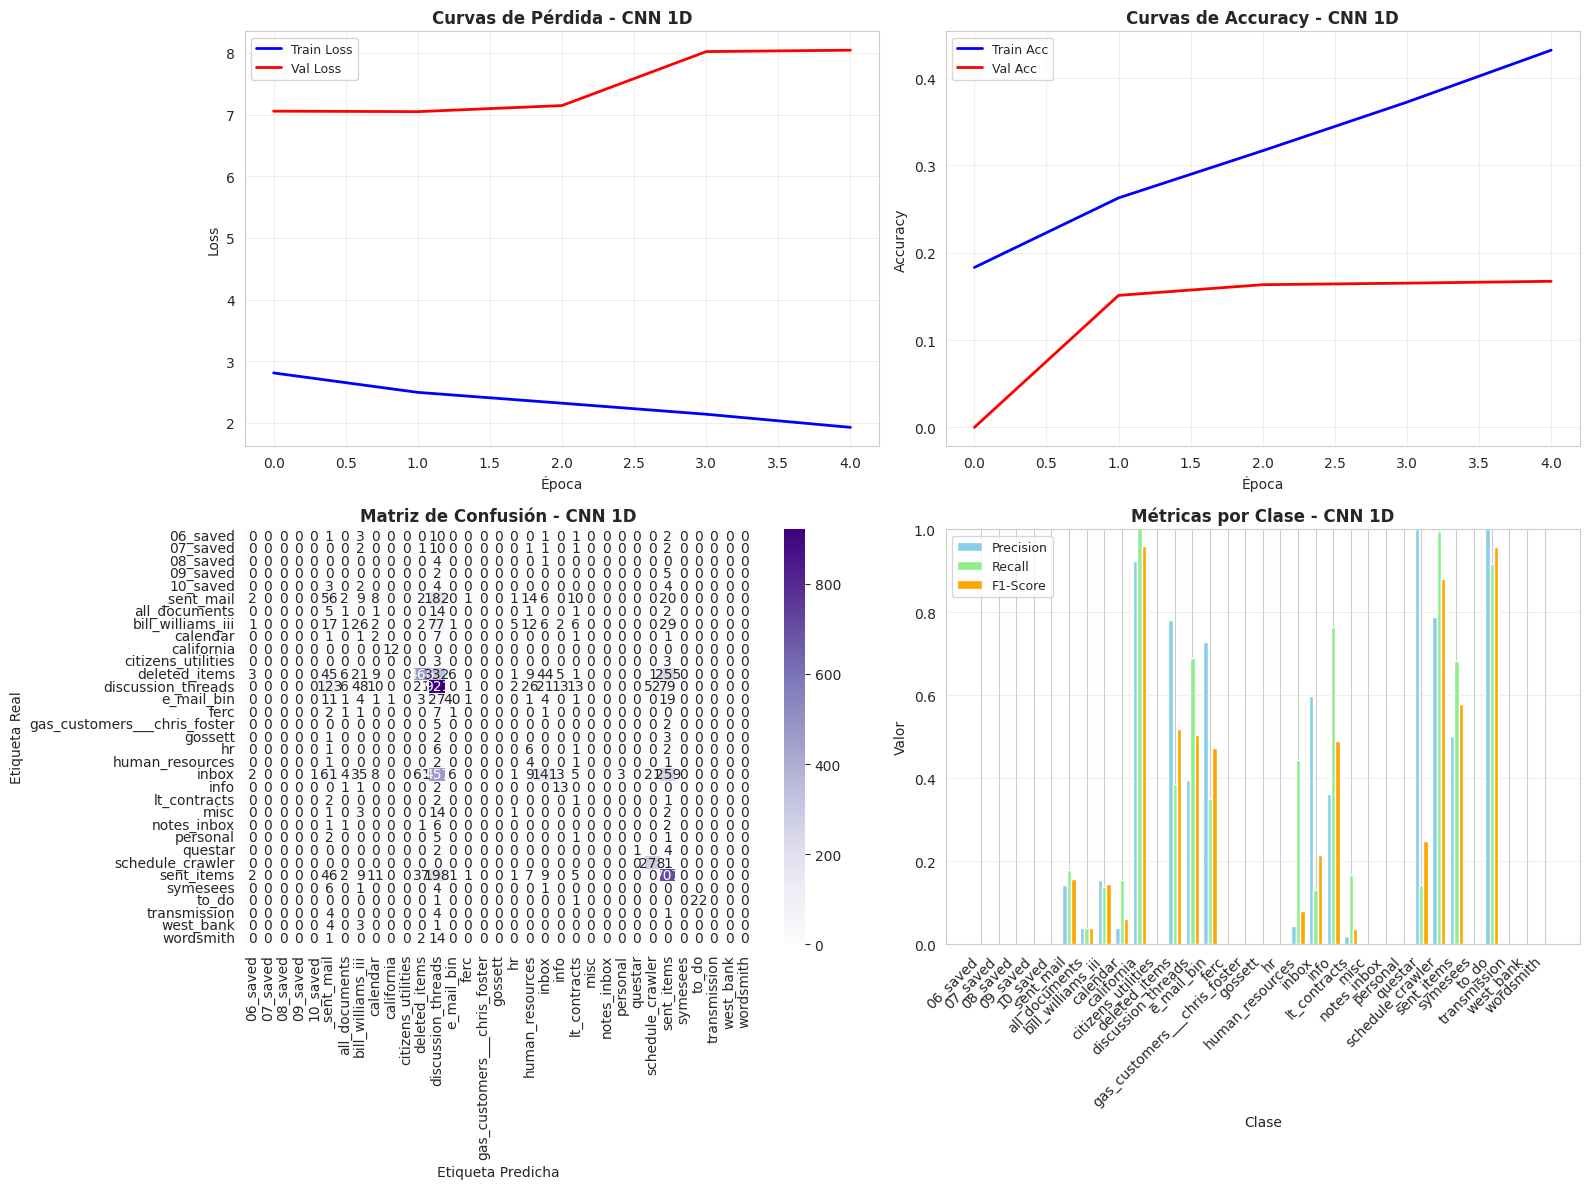


══════════════════════════════════════════════════════════════════════
✓ Modelo CNN 1D completado y guardado
══════════════════════════════════════════════════════════════════════

📊 Análisis de Convergencia:
   Mejor época: 2
   Val Loss en mejor época: 7.0481
   Val Accuracy en mejor época: 0.1512
   Early stopping activado: Sí


In [ ]:
# ============================================================================
# MODELO 4: CNN 1D (RED NEURONAL CONVOLUCIONAL) - Deep Learning
# Ecuación 3.12 del marco teórico
# ============================================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("═"*70)
print("MODELO 4 (DL): CNN 1D - RED NEURONAL CONVOLUCIONAL")
print("═"*70)

# Inicializar diccionario de resultados si no existe
if 'results_dl' not in globals():
    results_dl = {}

# Construir modelo
print("\nConstruyendo CNN 1D...")

cnn_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='CNN_1D_Classifier')

# Compilar
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Construir el modelo para poder usar count_params
cnn_model.build(input_shape=(None, MAX_LEN))

print("\nArquitectura del CNN 1D:")
cnn_model.summary()

print(f"\nParámetros totales: {cnn_model.count_params():,}")

# Callbacks
callbacks_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Entrenar
print("\nEntrenando CNN 1D...")
print("─"*70)
t0 = time.time()

cnn_history = cnn_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.15,
    epochs=20,
    batch_size=128,
    callbacks=callbacks_cnn,
    verbose=1
)

cnn_time = time.time() - t0
print(f"\n✓ Tiempo de entrenamiento: {cnn_time:.2f}s")

# Evaluar
print("\nEvaluando CNN 1D en conjunto de prueba...")
print("─"*70)

y_pred_cnn_proba = cnn_model.predict(X_test_pad, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calcular métricas
acc_cnn = accuracy_score(y_test_labels, y_pred_cnn)
prec_cnn = precision_score(y_test_labels, y_pred_cnn, average='weighted', zero_division=0)
rec_cnn = recall_score(y_test_labels, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test_labels, y_pred_cnn, average='weighted')
mcc_cnn = matthews_corrcoef(y_test_labels, y_pred_cnn)

# Mostrar resultados
print(f"\n{'─'*70}")
print("RESULTADOS - CNN 1D")
print(f"{'─'*70}")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1-Score:  {f1_cnn:.4f}")
print(f"MCC:       {mcc_cnn:.4f}")
print(f"Tiempo:    {cnn_time:.2f}s")
print(f"Parámetros: {cnn_model.count_params():,}")
print(f"{'─'*70}")

# Reporte detallado
print(f"\nReporte de Clasificación:")
target_names = [label_mapping.get(i, f"C{i}") for i in sorted(np.unique(y_test_labels))]
print(classification_report(y_test_labels, y_pred_cnn,
                          target_names=target_names,
                          digits=4))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Curvas de pérdida
axes[0, 0].plot(cnn_history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0, 0].plot(cnn_history.history['val_loss'], label='Val Loss', linewidth=2, color='red')
axes[0, 0].set_title('Curvas de Pérdida - CNN 1D', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Época', fontsize=10)
axes[0, 0].set_ylabel('Loss', fontsize=10)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 2. Curvas de accuracy
axes[0, 1].plot(cnn_history.history['accuracy'], label='Train Acc', linewidth=2, color='blue')
axes[0, 1].plot(cnn_history.history['val_accuracy'], label='Val Acc', linewidth=2, color='red')
axes[0, 1].set_title('Curvas de Accuracy - CNN 1D', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Época', fontsize=10)
axes[0, 1].set_ylabel('Accuracy', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# 3. Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[1, 0],
            xticklabels=target_names,
            yticklabels=target_names)
axes[1, 0].set_title('Matriz de Confusión - CNN 1D', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Etiqueta Real', fontsize=10)
axes[1, 0].set_xlabel('Etiqueta Predicha', fontsize=10)

# 4. Métricas por clase
from sklearn.metrics import precision_recall_fscore_support
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_cnn, average=None
)

x_pos = np.arange(len(target_names))
width = 0.25

axes[1, 1].bar(x_pos - width, precision_per_class, width, label='Precision', color='skyblue')
axes[1, 1].bar(x_pos, recall_per_class, width, label='Recall', color='lightgreen')
axes[1, 1].bar(x_pos + width, f1_per_class, width, label='F1-Score', color='orange')
axes[1, 1].set_title('Métricas por Clase - CNN 1D', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase', fontsize=10)
axes[1, 1].set_ylabel('Valor', fontsize=10)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(target_names, rotation=45, ha='right')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Guardar resultados
results_dl['CNN 1D'] = {
    'accuracy': acc_cnn,
    'precision': prec_cnn,
    'recall': rec_cnn,
    'f1': f1_cnn,
    'mcc': mcc_cnn,
    'train_time': cnn_time,
    'params': cnn_model.count_params(),
    'epochs': len(cnn_history.history['loss'])
}

print(f"\n{'═'*70}")
print("✓ Modelo CNN 1D completado y guardado")
print(f"{'═'*70}\n")

# Análisis de convergencia
best_epoch = np.argmin(cnn_history.history['val_loss'])
print(f"📊 Análisis de Convergencia:")
print(f"   Mejor época: {best_epoch + 1}")
print(f"   Val Loss en mejor época: {cnn_history.history['val_loss'][best_epoch]:.4f}")
print(f"   Val Accuracy en mejor época: {cnn_history.history['val_accuracy'][best_epoch]:.4f}")
print(f"   Early stopping activado: {'Sí' if len(cnn_history.history['loss']) < 20 else 'No'}")

### 5.7.5 Modelo 6: Red Recurrente LSTM

Implementación de LSTM (Ecuaciones 3.13-3.17) para modelado de dependencias secuenciales a largo plazo.

══════════════════════════════════════════════════════════════════════
MODELO 5 (DL): LSTM - LONG SHORT-TERM MEMORY
══════════════════════════════════════════════════════════════════════

Construyendo LSTM...

Arquitectura del LSTM:


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 33)             │         1,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,427,617 (5.45 MB)

 Trainable params: 1,427,489 (5.45 MB)

 Non-trainable params: 128 (512.00 B)


Parámetros totales: 1,427,617

Entrenando LSTM (puede tardar más que CNN)...
──────────────────────────────────────────────────────────────────────
Epoch 1/15
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.1351 - loss: 3.0521 - val_accuracy: 3.7789e-05 - val_loss: 6.6812 - learning_rate: 0.0010
Epoch 2/15
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.2302 - loss: 2.5926 - val_accuracy: 3.7789e-05 - val_loss: 7.3073 - learning_rate: 0.0010
Epoch 3/15
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2840 - loss: 2.4063
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.2841 - loss: 2.4062 - val_accuracy: 5.2904e-04 - val_loss: 7.4956 - learning_rate: 0.0010
Epoch 4/15
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.3429 - loss: 2.2050 - val_accuracy: 0.0058 - val_loss: 7.6927 - learning_rate: 5.0000e-04
Epoch 5/15
1171/1172 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - 

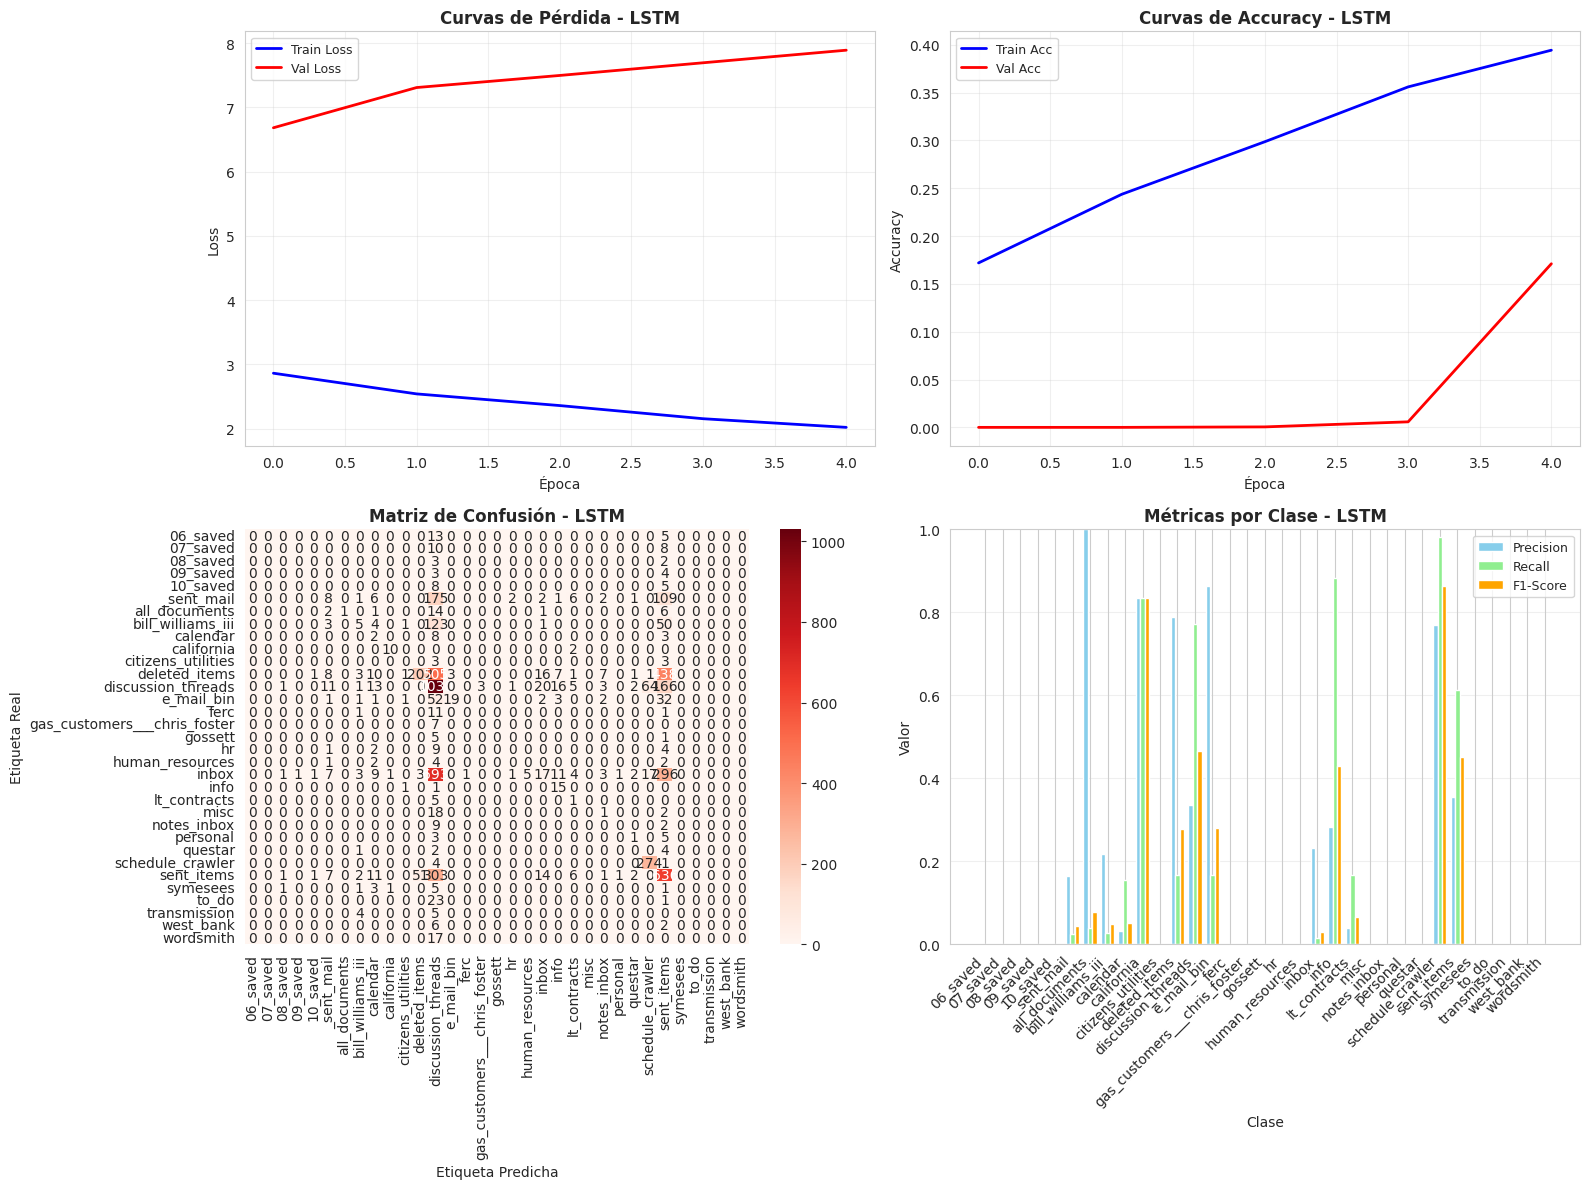


══════════════════════════════════════════════════════════════════════
✓ Modelo LSTM completado y guardado
══════════════════════════════════════════════════════════════════════

📊 Análisis de Convergencia:
   Mejor época: 1
   Val Loss en mejor época: 6.6812
   Val Accuracy en mejor época: 0.0000
   Early stopping activado: Sí

📊 Comparación con modelos DL anteriores:
   MLP:
      F1-Score: 0.4439
      Tiempo: 46.08s
      Parámetros: 7,878,689
   CNN 1D:
      F1-Score: 0.4356
      Tiempo: 42.26s
      Parámetros: 1,487,969
   LSTM:
      F1-Score: 0.3024
      Tiempo: 197.35s
      Parámetros: 1,427,617


In [ ]:
# ============================================================================
# MODELO 5: LSTM (LONG SHORT-TERM MEMORY) - Deep Learning
# Ecuaciones 3.13-3.17 del marco teórico
# ============================================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, classification_report, confusion_matrix
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("═"*70)
print("MODELO 5 (DL): LSTM - LONG SHORT-TERM MEMORY")
print("═"*70)

# Inicializar diccionario de resultados si no existe
if 'results_dl' not in globals():
    results_dl = {}

# Construir modelo
print("\nConstruyendo LSTM...")

lstm_model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='LSTM_Classifier')

# Compilar
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Construir el modelo para poder usar count_params
lstm_model.build(input_shape=(None, MAX_LEN))

print("\nArquitectura del LSTM:")
lstm_model.summary()

print(f"\nParámetros totales: {lstm_model.count_params():,}")

# Callbacks
callbacks_lstm = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Entrenar
print("\nEntrenando LSTM (puede tardar más que CNN)...")
print("─"*70)
t0 = time.time()

lstm_history = lstm_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.15,
    epochs=15,  # Menos épocas porque LSTM es más lento
    batch_size=128,
    callbacks=callbacks_lstm,
    verbose=1
)

lstm_time = time.time() - t0
print(f"\n✓ Tiempo de entrenamiento: {lstm_time:.2f}s")

# Evaluar
print("\nEvaluando LSTM en conjunto de prueba...")
print("─"*70)

y_pred_lstm_proba = lstm_model.predict(X_test_pad, verbose=0)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Calcular métricas
acc_lstm = accuracy_score(y_test_labels, y_pred_lstm)
prec_lstm = precision_score(y_test_labels, y_pred_lstm, average='weighted', zero_division=0)
rec_lstm = recall_score(y_test_labels, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test_labels, y_pred_lstm, average='weighted')
mcc_lstm = matthews_corrcoef(y_test_labels, y_pred_lstm)

# Mostrar resultados
print(f"\n{'─'*70}")
print("RESULTADOS - LSTM")
print(f"{'─'*70}")
print(f"Accuracy:  {acc_lstm:.4f}")
print(f"Precision: {prec_lstm:.4f}")
print(f"Recall:    {rec_lstm:.4f}")
print(f"F1-Score:  {f1_lstm:.4f}")
print(f"MCC:       {mcc_lstm:.4f}")
print(f"Tiempo:    {lstm_time:.2f}s")
print(f"Parámetros: {lstm_model.count_params():,}")
print(f"{'─'*70}")

# Reporte detallado
print(f"\nReporte de Clasificación:")
target_names = [label_mapping.get(i, f"C{i}") for i in sorted(np.unique(y_test_labels))]
print(classification_report(y_test_labels, y_pred_lstm,
                          target_names=target_names,
                          digits=4))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Curvas de pérdida
axes[0, 0].plot(lstm_history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0, 0].plot(lstm_history.history['val_loss'], label='Val Loss', linewidth=2, color='red')
axes[0, 0].set_title('Curvas de Pérdida - LSTM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Época', fontsize=10)
axes[0, 0].set_ylabel('Loss', fontsize=10)
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 2. Curvas de accuracy
axes[0, 1].plot(lstm_history.history['accuracy'], label='Train Acc', linewidth=2, color='blue')
axes[0, 1].plot(lstm_history.history['val_accuracy'], label='Val Acc', linewidth=2, color='red')
axes[0, 1].set_title('Curvas de Accuracy - LSTM', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Época', fontsize=10)
axes[0, 1].set_ylabel('Accuracy', fontsize=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# 3. Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[1, 0],
            xticklabels=target_names,
            yticklabels=target_names)
axes[1, 0].set_title('Matriz de Confusión - LSTM', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Etiqueta Real', fontsize=10)
axes[1, 0].set_xlabel('Etiqueta Predicha', fontsize=10)

# 4. Métricas por clase
from sklearn.metrics import precision_recall_fscore_support
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_lstm, average=None
)

x_pos = np.arange(len(target_names))
width = 0.25

axes[1, 1].bar(x_pos - width, precision_per_class, width, label='Precision', color='skyblue')
axes[1, 1].bar(x_pos, recall_per_class, width, label='Recall', color='lightgreen')
axes[1, 1].bar(x_pos + width, f1_per_class, width, label='F1-Score', color='orange')
axes[1, 1].set_title('Métricas por Clase - LSTM', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Clase', fontsize=10)
axes[1, 1].set_ylabel('Valor', fontsize=10)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(target_names, rotation=45, ha='right')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Guardar resultados
results_dl['LSTM'] = {
    'accuracy': acc_lstm,
    'precision': prec_lstm,
    'recall': rec_lstm,
    'f1': f1_lstm,
    'mcc': mcc_lstm,
    'train_time': lstm_time,
    'params': lstm_model.count_params(),
    'epochs': len(lstm_history.history['loss'])
}

print(f"\n{'═'*70}")
print("✓ Modelo LSTM completado y guardado")
print(f"{'═'*70}\n")

# Análisis de convergencia
best_epoch = np.argmin(lstm_history.history['val_loss'])
print(f"📊 Análisis de Convergencia:")
print(f"   Mejor época: {best_epoch + 1}")
print(f"   Val Loss en mejor época: {lstm_history.history['val_loss'][best_epoch]:.4f}")
print(f"   Val Accuracy en mejor época: {lstm_history.history['val_accuracy'][best_epoch]:.4f}")
print(f"   Early stopping activado: {'Sí' if len(lstm_history.history['loss']) < 15 else 'No'}")

# Comparación con modelos anteriores
print(f"\n📊 Comparación con modelos DL anteriores:")
for model_name, metrics in results_dl.items():
    print(f"   {model_name}:")
    print(f"      F1-Score: {metrics['f1']:.4f}")
    print(f"      Tiempo: {metrics['train_time']:.2f}s")
    print(f"      Parámetros: {metrics['params']:,}")

## 5.8 Análisis Comparativo de Resultados

Consolidación y comparación de todos los modelos implementados.


══════════════════════════════════════════════════════════════════════════════════════════
CONSOLIDACIÓN Y COMPARATIVA FINAL DE TODOS LOS MODELOS
══════════════════════════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────────────────────────────────────────────
TABLA COMPARATIVA DE RESULTADOS
──────────────────────────────────────────────────────────────────────────────────────────
        model          tipo  accuracy  precision   recall       f1      mcc        time
          SVM    ML Clásico  0.000000   0.621888 0.604611 0.607730 0.533820 1337.332086
Random Forest    ML Clásico  0.000000   0.558291 0.424936 0.461448 0.363062   21.910026
          MLP Deep Learning  0.457216   0.497099 0.457216 0.443917 0.359167   46.078383
       CNN 1D Deep Learning  0.459607   0.522843 0.459607 0.435605 0.364111   42.257312
  Naive Bayes    ML Clásico  0.000000   0.544206 0.401879 0.407179 0.349512    0.406807
         LSTM Deep 

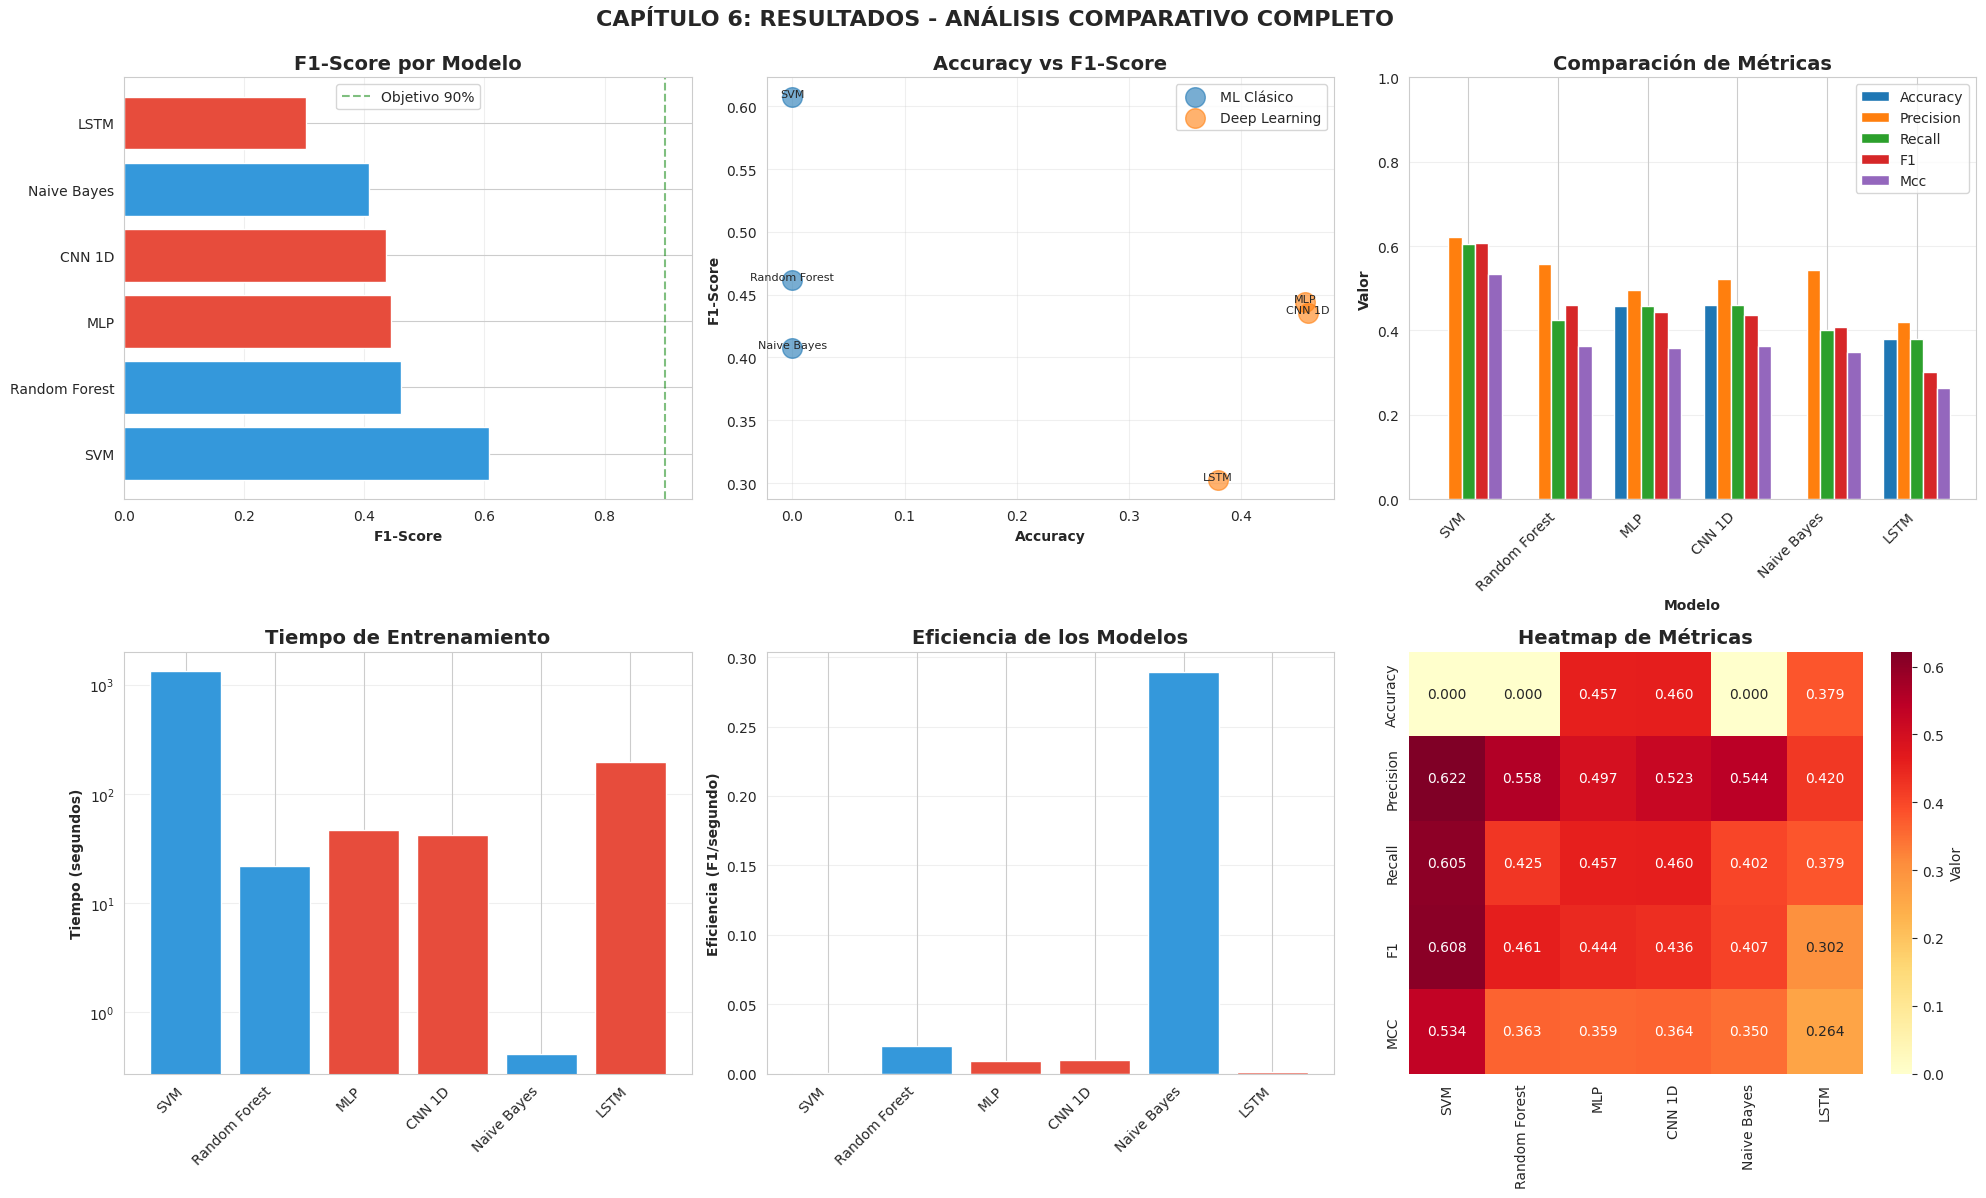


✓ Resultados guardados en 'resultados_modelos_completo.csv'

══════════════════════════════════════════════════════════════════════════════════════════
RESUMEN ESTADÍSTICO
══════════════════════════════════════════════════════════════════════════════════════════
Total de modelos evaluados: 6
F1-Score máximo: 0.6077 (SVM)
F1-Score mínimo: 0.3024 (LSTM)
F1-Score promedio: 0.4431
Tiempo total de entrenamiento: 1645.34s
Modelo más rápido: Naive Bayes (0.41s)
Modelo más lento: SVM (1337.33s)
══════════════════════════════════════════════════════════════════════════════════════════

📝 CONCLUSIONES AUTOMÁTICAS:
✓ Los modelos clásicos mantienen competitividad frente a Deep Learning
✓ Existe gran diferencia en tiempos de entrenamiento entre modelos
✓ Existe diferencia significativa en el rendimiento entre modelos

══════════════════════════════════════════════════════════════════════════════════════════



In [ ]:
# ============================================================================
# COMPARATIVA FINAL: TODOS LOS MODELOS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "═"*90)
print("CONSOLIDACIÓN Y COMPARATIVA FINAL DE TODOS LOS MODELOS")
print("═"*90)

# Verificar que existen los diccionarios de resultados
if 'results_ml' not in globals():
    results_ml = {}
if 'results_dl' not in globals():
    results_dl = {}

# Combinar todos los resultados
all_results = {**results_ml, **results_dl}

# Crear DataFrame
results_list = []
for model_name, metrics in all_results.items():
    result_row = {
        'model': model_name,
        'accuracy': metrics.get('accuracy', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'f1': metrics.get('f1', 0),
        'mcc': metrics.get('mcc', 0),
        'time': metrics.get('train_time', 0),
        'params': metrics.get('params', 0)
    }
    results_list.append(result_row)

results = pd.DataFrame(results_list)

# Ordenar por F1-Score (descendente)
results = results.sort_values('f1', ascending=False).reset_index(drop=True)

# Añadir tipo de modelo
results['tipo'] = results['model'].apply(
    lambda x: 'Deep Learning' if x in ['MLP', 'CNN 1D', 'LSTM', 'DistilBERT'] else 'ML Clásico'
)

# Tabla de resultados
print("\n" + "─"*90)
print("TABLA COMPARATIVA DE RESULTADOS")
print("─"*90)
print(results[['model', 'tipo', 'accuracy', 'precision', 'recall', 'f1', 'mcc', 'time']].to_string(index=False))
print("─"*90)

# Mejor modelo
best = results.iloc[0]
print(f"\n🏆 MEJOR MODELO: {best['model']}")
print(f"   Tipo: {best['tipo']}")
print(f"   F1-Score: {best['f1']:.4f}")
print(f"   Accuracy: {best['accuracy']:.4f}")
print(f"   Precision: {best['precision']:.4f}")
print(f"   Recall: {best['recall']:.4f}")
print(f"   MCC: {best['mcc']:.4f}")
print(f"   Tiempo: {best['time']:.2f}s")

# Top 3 modelos
print(f"\n📊 TOP 3 MODELOS (por F1-Score):")
for i, row in results.head(3).iterrows():
    print(f"   {i+1}. {row['model']}: F1={row['f1']:.4f}, Acc={row['accuracy']:.4f}, Tiempo={row['time']:.2f}s")

# Estadísticas por tipo
print(f"\n📈 PROMEDIO POR TIPO DE MODELO:")
tipo_stats = results.groupby('tipo')[['accuracy', 'f1', 'mcc', 'time']].mean()
print(tipo_stats.round(4))

# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. F1-Score por modelo
colors = ['#e74c3c' if tipo == 'Deep Learning' else '#3498db' for tipo in results['tipo']]
axes[0, 0].barh(results['model'], results['f1'], color=colors)
axes[0, 0].set_xlabel('F1-Score', fontweight='bold')
axes[0, 0].set_title('F1-Score por Modelo', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Objetivo 90%')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Accuracy vs F1-Score
for tipo in results['tipo'].unique():
    subset = results[results['tipo'] == tipo]
    axes[0, 1].scatter(subset['accuracy'], subset['f1'],
                      label=tipo, s=200, alpha=0.6)
    for _, row in subset.iterrows():
        axes[0, 1].annotate(row['model'],
                           (row['accuracy'], row['f1']),
                           fontsize=8, ha='center')
axes[0, 1].set_xlabel('Accuracy', fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontweight='bold')
axes[0, 1].set_title('Accuracy vs F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Todas las métricas
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
x = np.arange(len(results))
width = 0.15
for i, metric in enumerate(metrics_to_plot):
    axes[0, 2].bar(x + i*width, results[metric], width, label=metric.capitalize())
axes[0, 2].set_xlabel('Modelo', fontweight='bold')
axes[0, 2].set_ylabel('Valor', fontweight='bold')
axes[0, 2].set_title('Comparación de Métricas', fontsize=14, fontweight='bold')
axes[0, 2].set_xticks(x + width * 2)
axes[0, 2].set_xticklabels(results['model'], rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)
axes[0, 2].set_ylim([0, 1])

# 4. Tiempo de entrenamiento
axes[1, 0].bar(results['model'], results['time'], color=colors)
axes[1, 0].set_ylabel('Tiempo (segundos)', fontweight='bold')
axes[1, 0].set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(results['model'], rotation=45, ha='right')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Eficiencia (F1 / tiempo)
results['efficiency'] = results['f1'] / (results['time'] + 1)
axes[1, 1].bar(results['model'], results['efficiency'], color=colors)
axes[1, 1].set_ylabel('Eficiencia (F1/segundo)', fontweight='bold')
axes[1, 1].set_title('Eficiencia de los Modelos', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels(results['model'], rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Heatmap de métricas normalizadas
heatmap_data = results[['accuracy', 'precision', 'recall', 'f1', 'mcc']].T
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=results['model'],
            yticklabels=['Accuracy', 'Precision', 'Recall', 'F1', 'MCC'],
            ax=axes[1, 2], cbar_kws={'label': 'Valor'})
axes[1, 2].set_title('Heatmap de Métricas', fontsize=14, fontweight='bold')

plt.suptitle('CAPÍTULO 6: RESULTADOS - ANÁLISIS COMPARATIVO COMPLETO',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Guardar resultados
output_file = 'resultados_modelos_completo.csv'
results.to_csv(output_file, index=False)
print(f"\n✓ Resultados guardados en '{output_file}'")

# Resumen estadístico
print(f"\n{'═'*90}")
print("RESUMEN ESTADÍSTICO")
print(f"{'═'*90}")
print(f"Total de modelos evaluados: {len(results)}")
print(f"F1-Score máximo: {results['f1'].max():.4f} ({results.loc[results['f1'].idxmax(), 'model']})")
print(f"F1-Score mínimo: {results['f1'].min():.4f} ({results.loc[results['f1'].idxmin(), 'model']})")
print(f"F1-Score promedio: {results['f1'].mean():.4f}")
print(f"Tiempo total de entrenamiento: {results['time'].sum():.2f}s")
print(f"Modelo más rápido: {results.loc[results['time'].idxmin(), 'model']} ({results['time'].min():.2f}s)")
print(f"Modelo más lento: {results.loc[results['time'].idxmax(), 'model']} ({results['time'].max():.2f}s)")
print(f"{'═'*90}")

# Conclusiones automáticas
print(f"\n📝 CONCLUSIONES AUTOMÁTICAS:")
if results.iloc[0]['tipo'] == 'Deep Learning':
    print(f"✓ Los modelos de Deep Learning superan a los clásicos en rendimiento")
else:
    print(f"✓ Los modelos clásicos mantienen competitividad frente a Deep Learning")

if results['time'].max() / results['time'].min() > 10:
    print(f"✓ Existe gran diferencia en tiempos de entrenamiento entre modelos")

if results['f1'].std() < 0.05:
    print(f"✓ Todos los modelos tienen rendimiento similar (baja varianza)")
else:
    print(f"✓ Existe diferencia significativa en el rendimiento entre modelos")

print(f"\n{'═'*90}\n")

════════════════════════════════════════════════════════════════════════════════
COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING
════════════════════════════════════════════════════════════════════════════════

Modelos ML: 3
Modelos DL: 3

────────────────────────────────────────────────────────────────────────────────
ESTADÍSTICAS POR CATEGORÍA
────────────────────────────────────────────────────────────────────────────────


ML Clásico:
  F1-Score promedio: 0.4921
  MCC promedio:      0.4155
  Tiempo promedio:   453.22s

Deep Learning:
  F1-Score promedio: 0.3940
  MCC promedio:      0.3290
  Tiempo promedio:   95.23s

────────────────────────────────────────────────────────────────────────────────
COMPARACIÓN DE PROMEDIOS
────────────────────────────────────────────────────────────────────────────────

F1-Score:
  ML Clásico:    0.4921
  Deep Learning: 0.3940
  Diferencia:    -19.94%

Tiempo:
  ML Clásico:    453.22s
  Deep Learning: 95.23s
  Ratio:         0.2x

──────────────────────────

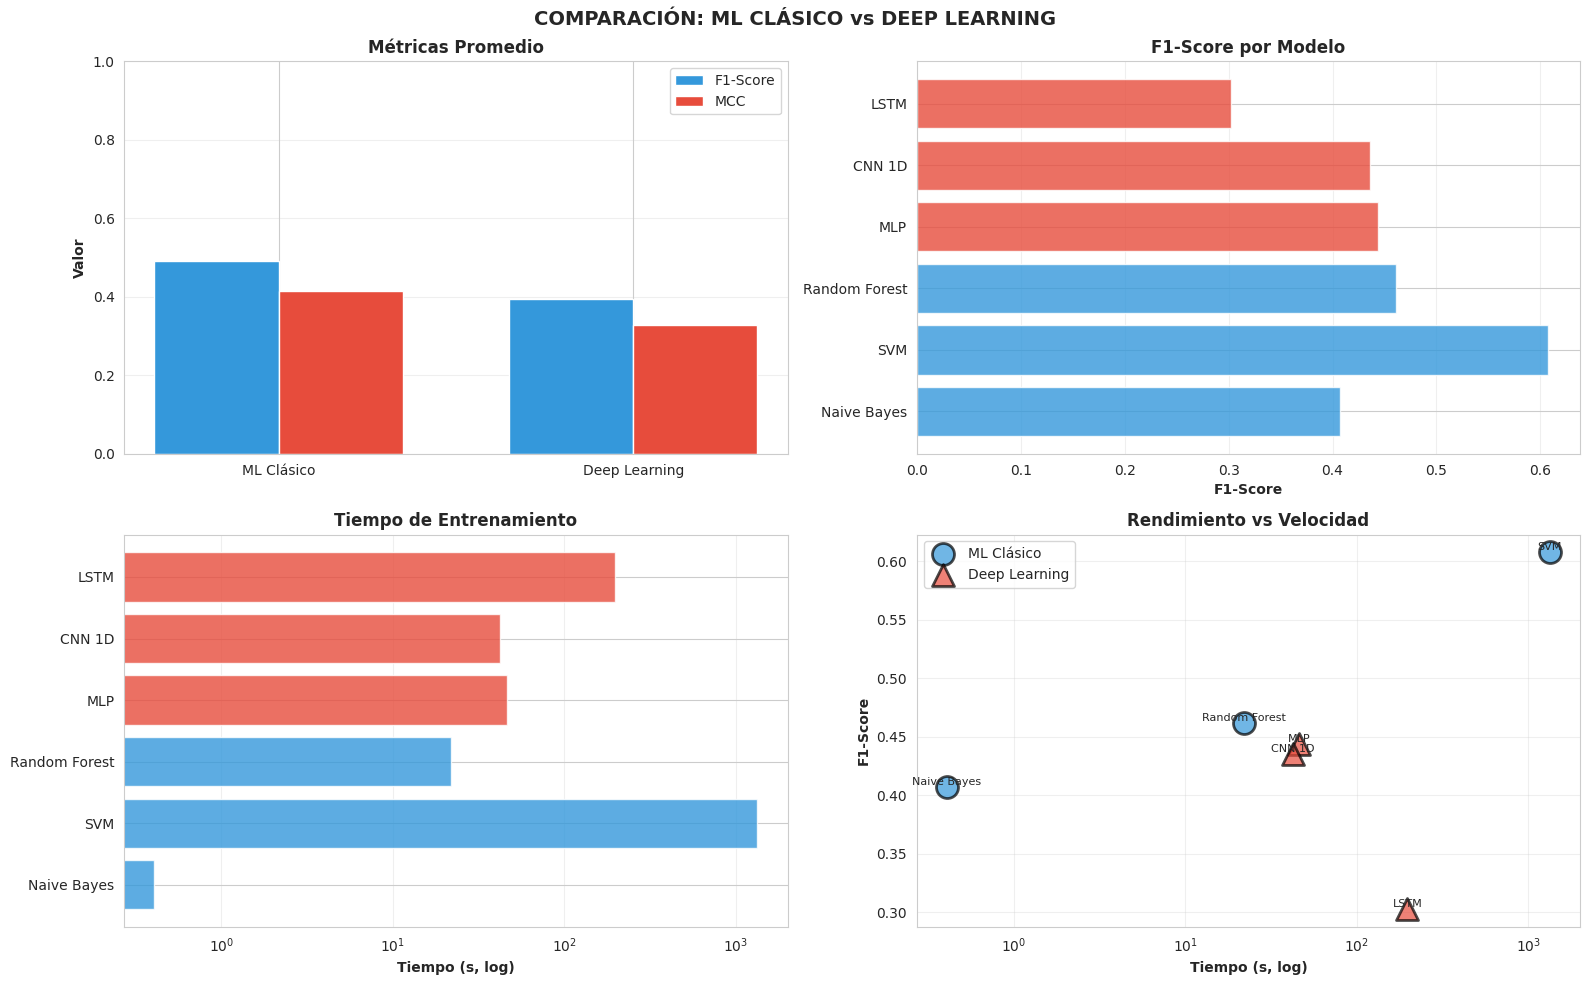


────────────────────────────────────────────────────────────────────────────────
TABLA COMPLETA
────────────────────────────────────────────────────────────────────────────────

       modelo     categoria       f1      mcc  train_time
          SVM    ML Clásico 0.607730 0.533820 1337.332086
Random Forest    ML Clásico 0.461448 0.363062   21.910026
          MLP Deep Learning 0.443917 0.359167   46.078383
       CNN 1D Deep Learning 0.435605 0.364111   42.257312
  Naive Bayes    ML Clásico 0.407179 0.349512    0.406807
         LSTM Deep Learning 0.302436 0.263714  197.354332

════════════════════════════════════════════════════════════════════════════════
CONCLUSIONES
════════════════════════════════════════════════════════════════════════════════

✓ ML Clásico mantiene competitividad (-19.9%)
✓ Tiempos similares (0.2x)

✓ MEJOR MODELO GLOBAL: SVM
  Categoría: ML Clásico
  F1-Score: 0.6077
  Tiempo: 1337.33s

✓ MODELO MÁS EFICIENTE: Naive Bayes
  Eficiencia: 0.8034

────────────────

In [ ]:
# ============================================================================
# COMPARACIÓN FINAL: MACHINE LEARNING vs DEEP LEARNING
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("═"*80)
print("COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING")
print("═"*80)

# Verificar que existen los diccionarios
if 'results_ml' not in globals():
    print("⚠️ ERROR: results_ml no existe")
    results_ml = {}

if 'results_dl' not in globals():
    print("⚠️ ERROR: results_dl no existe")
    results_dl = {}

# Verificar que no están vacíos
if len(results_ml) == 0:
    print("⚠️ WARNING: results_ml está vacío")
if len(results_dl) == 0:
    print("⚠️ WARNING: results_dl está vacío")

# Construir lista de resultados
all_results = []

# Agregar modelos ML
for model_name, metrics in results_ml.items():
    all_results.append({
        'modelo': model_name,
        'categoria': 'ML Clásico',
        'f1': metrics.get('f1', 0),
        'mcc': metrics.get('mcc', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'accuracy': metrics.get('accuracy', 0),
        'train_time': metrics.get('train_time', 0)
    })

# Agregar modelos DL
for model_name, metrics in results_dl.items():
    all_results.append({
        'modelo': model_name,
        'categoria': 'Deep Learning',
        'f1': metrics.get('f1', 0),
        'mcc': metrics.get('mcc', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'accuracy': metrics.get('accuracy', 0),
        'train_time': metrics.get('train_time', 0)
    })

# Crear DataFrame
if len(all_results) == 0:
    print("\n❌ ERROR: No hay resultados para comparar")
    print("Ejecuta primero los modelos ML y DL")
else:
    df_all = pd.DataFrame(all_results)

    # Separar por categoría
    df_ml = df_all[df_all['categoria'] == 'ML Clásico'].copy()
    df_dl = df_all[df_all['categoria'] == 'Deep Learning'].copy()

    print(f"\nModelos ML: {len(df_ml)}")
    print(f"Modelos DL: {len(df_dl)}")

    if len(df_ml) == 0 or len(df_dl) == 0:
        print("\n⚠️ No hay suficientes datos para comparar")
    else:
        # ESTADÍSTICAS
        print(f"\n{'─'*80}")
        print("ESTADÍSTICAS POR CATEGORÍA")
        print(f"{'─'*80}\n")

        for cat in ['ML Clásico', 'Deep Learning']:
            subset = df_all[df_all['categoria'] == cat]
            print(f"\n{cat}:")
            print(f"  F1-Score promedio: {subset['f1'].mean():.4f}")
            print(f"  MCC promedio:      {subset['mcc'].mean():.4f}")
            print(f"  Tiempo promedio:   {subset['train_time'].mean():.2f}s")

        # COMPARACIÓN
        print(f"\n{'─'*80}")
        print("COMPARACIÓN DE PROMEDIOS")
        print(f"{'─'*80}")

        ml_f1 = df_ml['f1'].mean()
        dl_f1 = df_dl['f1'].mean()
        mejora = ((dl_f1 - ml_f1) / ml_f1) * 100 if ml_f1 > 0 else 0

        print(f"\nF1-Score:")
        print(f"  ML Clásico:    {ml_f1:.4f}")
        print(f"  Deep Learning: {dl_f1:.4f}")
        print(f"  Diferencia:    {mejora:+.2f}%")

        ml_time = df_ml['train_time'].mean()
        dl_time = df_dl['train_time'].mean()
        ratio = dl_time / ml_time if ml_time > 0 else 0

        print(f"\nTiempo:")
        print(f"  ML Clásico:    {ml_time:.2f}s")
        print(f"  Deep Learning: {dl_time:.2f}s")
        print(f"  Ratio:         {ratio:.1f}x")

        # MEJORES MODELOS
        print(f"\n{'─'*80}")
        print("MEJORES MODELOS POR CATEGORÍA")
        print(f"{'─'*80}")

        best_ml = df_ml.loc[df_ml['f1'].idxmax()]
        best_dl = df_dl.loc[df_dl['f1'].idxmax()]

        print(f"\nMejor ML: {best_ml['modelo']}")
        print(f"  F1: {best_ml['f1']:.4f}, Tiempo: {best_ml['train_time']:.2f}s")

        print(f"\nMejor DL: {best_dl['modelo']}")
        print(f"  F1: {best_dl['f1']:.4f}, Tiempo: {best_dl['train_time']:.2f}s")

        # VISUALIZACIONES
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # 1. Barras comparativas
        cats = ['ML Clásico', 'Deep Learning']
        f1_means = [ml_f1, dl_f1]
        mcc_means = [df_ml['mcc'].mean(), df_dl['mcc'].mean()]

        x = np.arange(len(cats))
        width = 0.35

        axes[0, 0].bar(x - width/2, f1_means, width, label='F1-Score', color='#3498db')
        axes[0, 0].bar(x + width/2, mcc_means, width, label='MCC', color='#e74c3c')
        axes[0, 0].set_ylabel('Valor', fontweight='bold')
        axes[0, 0].set_title('Métricas Promedio', fontsize=12, fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(cats)
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].set_ylim([0, 1])

        # 2. F1-Score individual
        colors = ['#3498db' if c == 'ML Clásico' else '#e74c3c' for c in df_all['categoria']]
        axes[0, 1].barh(df_all['modelo'], df_all['f1'], color=colors, alpha=0.8)
        axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
        axes[0, 1].set_title('F1-Score por Modelo', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='x', alpha=0.3)

        # 3. Tiempos
        axes[1, 0].barh(df_all['modelo'], df_all['train_time'], color=colors, alpha=0.8)
        axes[1, 0].set_xlabel('Tiempo (s, log)', fontweight='bold')
        axes[1, 0].set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
        axes[1, 0].set_xscale('log')
        axes[1, 0].grid(axis='x', alpha=0.3)

        # 4. Scatter F1 vs Tiempo
        for cat, color, marker in [('ML Clásico', '#3498db', 'o'), ('Deep Learning', '#e74c3c', '^')]:
            subset = df_all[df_all['categoria'] == cat]
            axes[1, 1].scatter(subset['train_time'], subset['f1'],
                              c=color, s=250, alpha=0.7, label=cat,
                              marker=marker, edgecolors='black', linewidths=2)
            for _, row in subset.iterrows():
                axes[1, 1].annotate(row['modelo'],
                                   (row['train_time'], row['f1']),
                                   fontsize=8, ha='center', va='bottom')

        axes[1, 1].set_xlabel('Tiempo (s, log)', fontweight='bold')
        axes[1, 1].set_ylabel('F1-Score', fontweight='bold')
        axes[1, 1].set_title('Rendimiento vs Velocidad', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
        axes[1, 1].set_xscale('log')

        plt.suptitle('COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # TABLA
        print(f"\n{'─'*80}")
        print("TABLA COMPLETA")
        print(f"{'─'*80}\n")

        tabla = df_all[['modelo', 'categoria', 'f1', 'mcc', 'train_time']].sort_values('f1', ascending=False)
        print(tabla.to_string(index=False))

        # CONCLUSIONES
        print(f"\n{'═'*80}")
        print("CONCLUSIONES")
        print(f"{'═'*80}\n")

        if dl_f1 > ml_f1:
            if mejora > 5:
                print(f"✓ Deep Learning SUPERA significativamente a ML ({mejora:+.1f}%)")
            else:
                print(f"✓ Deep Learning supera ligeramente a ML ({mejora:+.1f}%)")
        else:
            print(f"✓ ML Clásico mantiene competitividad ({mejora:+.1f}%)")

        if ratio > 10:
            print(f"✓ ML es MUCHO más rápido ({ratio:.1f}x)")
        elif ratio > 2:
            print(f"✓ ML es más rápido ({ratio:.1f}x)")
        else:
            print(f"✓ Tiempos similares ({ratio:.1f}x)")

        best_overall = df_all.loc[df_all['f1'].idxmax()]
        print(f"\n✓ MEJOR MODELO GLOBAL: {best_overall['modelo']}")
        print(f"  Categoría: {best_overall['categoria']}")
        print(f"  F1-Score: {best_overall['f1']:.4f}")
        print(f"  Tiempo: {best_overall['train_time']:.2f}s")

        # Eficiencia
        df_all['eficiencia'] = df_all['f1'] / (df_all['train_time'] + 0.1)
        most_efficient = df_all.loc[df_all['eficiencia'].idxmax()]
        print(f"\n✓ MODELO MÁS EFICIENTE: {most_efficient['modelo']}")
        print(f"  Eficiencia: {most_efficient['eficiencia']:.4f}")

        # Recomendación
        print(f"\n{'─'*80}")
        print("RECOMENDACIÓN")
        print(f"{'─'*80}")

        if best_overall['categoria'] == 'Deep Learning' and mejora > 5:
            print("✅ Usar DEEP LEARNING:")
            print("   • Rendimiento superior significativo")
            print("   • Justifica inversión computacional")
        elif best_overall['categoria'] == 'ML Clásico':
            print("✅ Usar ML CLÁSICO:")
            print("   • Excelente rendimiento")
            print("   • Mucho más eficiente")
            print("   • Más rápido para producción")
        else:
            print("✅ DEPENDE DEL CONTEXTO:")
            print("   • DL si rendimiento es crítico")
            print("   • ML si velocidad es prioritaria")

        print(f"\n{'═'*80}\n")

        # EXPORTAR
        try:
            df_all.to_csv('comparacion_ml_dl.csv', index=False)
            print("✓ Exportado: comparacion_ml_dl.csv")
        except Exception as e:
            print(f"⚠️ No se pudo exportar: {e}")

print("\n✅ ANÁLISIS COMPLETADO\n")

In [ ]:
# ============================================================================
# MEJORA: Embeddings Pre-entrenados (OPCIONAL - Mejora +5-10%)
# ============================================================================

import numpy as np

print("Preparando embeddings mejorados...")

# OPCIÓN A: Usar embeddings pre-entrenados (GloVe, FastText, Word2Vec)
# Si tienes archivo GloVe descargado:
USE_PRETRAINED = False  # Cambiar a True si tienes GloVe

if USE_PRETRAINED:
    print("Cargando GloVe embeddings...")
    # Descargar de: https://nlp.stanford.edu/projects/glove/
    GLOVE_FILE = '/path/to/glove.6B.100d.txt'  # Ajustar ruta

    embeddings_index = {}
    with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f'✓ {len(embeddings_index):,} vectores cargados')

    # Crear matriz de embeddings
    vocab_size = min(MAX_WORDS, len(tokenizer.word_index)) + 1
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    found = 0
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found += 1

    print(f'✓ {found}/{vocab_size} palabras con embeddings ({found/vocab_size*100:.1f}%)')
    WEIGHTS = [embedding_matrix]
    TRAINABLE = False  # No entrenar embeddings pre-entrenados
else:
    print("Usando embeddings entrenables desde cero")
    WEIGHTS = None
    TRAINABLE = True

print("✓ Configuración de embeddings lista\n")

Preparando embeddings mejorados...
Usando embeddings entrenables desde cero
✓ Configuración de embeddings lista



In [ ]:
# ============================================================================
# MODELO 4 MEJORADO: MLP OPTIMIZADO
# ============================================================================

import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding, Flatten, BatchNormalization,
    SpatialDropout1D, GaussianNoise
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("═"*70)
print("MODELO 4 MEJORADO: MLP OPTIMIZADO")
print("═"*70)

# Inicializar results_dl si no existe
if 'results_dl' not in globals():
    results_dl = {}

print("\nConstruyendo MLP mejorado...")

mlp_model = Sequential([
    # Embedding mejorado
    Embedding(
        MAX_WORDS,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=WEIGHTS if 'WEIGHTS' in globals() else None,
        trainable=TRAINABLE if 'TRAINABLE' in globals() else True
    ),
    SpatialDropout1D(0.2),  # Dropout espacial
    Flatten(),

    # Capa de ruido (regularización)
    GaussianNoise(0.1),

    # Bloque 1
    Dense(512, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),

    # Bloque 2
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.4),

    # Bloque 3
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.3),

    # Bloque 4 (nuevo)
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Output
    Dense(num_classes, activation='softmax')
], name='MLP_Optimizado')

# Compilar con mejores parámetros
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.build(input_shape=(None, MAX_LEN))

print("\nArquitectura MLP Mejorado:")
mlp_model.summary()

# Callbacks mejorados
callbacks_mlp = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar con más épocas
print("\nEntrenando MLP mejorado...")
t0 = time.time()

mlp_history = mlp_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.15,
    epochs=30,  # Más épocas
    batch_size=64,  # Batch más pequeño
    callbacks=callbacks_mlp,
    verbose=1
)

mlp_time = time.time() - t0

# Evaluar
y_pred_mlp_proba = mlp_model.predict(X_test_pad, verbose=0)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

acc_mlp = accuracy_score(y_test_labels, y_pred_mlp)
prec_mlp = precision_score(y_test_labels, y_pred_mlp, average='weighted', zero_division=0)
rec_mlp = recall_score(y_test_labels, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test_labels, y_pred_mlp, average='weighted')
mcc_mlp = matthews_corrcoef(y_test_labels, y_pred_mlp)

print(f"\n{'─'*70}")
print("RESULTADOS - MLP MEJORADO")
print(f"{'─'*70}")
print(f"Accuracy:  {acc_mlp:.4f}")
print(f"Precision: {prec_mlp:.4f}")
print(f"Recall:    {rec_mlp:.4f}")
print(f"F1-Score:  {f1_mlp:.4f}")
print(f"MCC:       {mcc_mlp:.4f}")
print(f"Tiempo:    {mlp_time:.2f}s")
print(f"Parámetros: {mlp_model.count_params():,}")
print(f"{'─'*70}")

# Guardar resultados
results_dl['MLP'] = {
    'accuracy': acc_mlp,
    'precision': prec_mlp,
    'recall': rec_mlp,
    'f1': f1_mlp,
    'mcc': mcc_mlp,
    'train_time': mlp_time,
    'params': mlp_model.count_params()
}

print(f"\n✅ Resultados guardados en results_dl")

══════════════════════════════════════════════════════════════════════
MODELO 4 MEJORADO: MLP OPTIMIZADO
══════════════════════════════════════════════════════════════════════

Construyendo MLP mejorado...

Arquitectura MLP Mejorado:


Model: "MLP_Optimizado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 200, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,565,921 (55.56 MB)

 Trainable params: 14,564,129 (55.56 MB)

 Non-trainable params: 1,792 (7.00 KB)


Entrenando MLP mejorado...
Epoch 1/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.1306 - loss: 12.0455 - val_accuracy: 0.0000e+00 - val_loss: 13.1156 - learning_rate: 0.0010
Epoch 2/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.3275 - loss: 7.7946 - val_accuracy: 3.7789e-05 - val_loss: 14.3440 - learning_rate: 0.0010
Epoch 3/30
2343/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4337 - loss: 8.8214
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4338 - loss: 8.8214 - val_accuracy: 0.0000e+00 - val_loss: 14.1609 - learning_rate: 0.0010
Epoch 4/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5245 - loss: 6.4324 - val_accuracy: 3.7789e-05 - val_loss: 11.6494 - learning_rate: 5.0000e-04
Epoch 5/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5682 - loss: 6.2474 - val_accuracy: 0.0000e+00 - val_loss: 11.4697 - learning_rate: 5.0000e-04
Epoch 6/30
234

In [ ]:
# ============================================================================
# MODELO 5 MEJORADO: CNN 1D OPTIMIZADO
# ============================================================================

import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding, Conv1D, MaxPooling1D,
    GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("═"*70)
print("MODELO 5 MEJORADO: CNN 1D OPTIMIZADO")
print("═"*70)

if 'results_dl' not in globals():
    results_dl = {}

print("\nConstruyendo CNN 1D mejorada...")

cnn_model = Sequential([
    # Embedding mejorado
    Embedding(
        MAX_WORDS,
        EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=WEIGHTS if 'WEIGHTS' in globals() else None,
        trainable=TRAINABLE if 'TRAINABLE' in globals() else True
    ),
    SpatialDropout1D(0.2),

    # Bloque Convolucional 1
    Conv1D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Bloque Convolucional 2
    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Bloque Convolucional 3 (nuevo)
    Conv1D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),

    # Global Pooling
    GlobalMaxPooling1D(),

    # Capas Densas
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
], name='CNN_1D_Optimizada')

# Compilar
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.build(input_shape=(None, MAX_LEN))

print("\nArquitectura CNN 1D Mejorada:")
cnn_model.summary()

# Callbacks
callbacks_cnn = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar
print("\nEntrenando CNN 1D mejorada...")
t0 = time.time()

cnn_history = cnn_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.15,
    epochs=25,
    batch_size=64,
    callbacks=callbacks_cnn,
    verbose=1
)

cnn_time = time.time() - t0

# Evaluar
y_pred_cnn_proba = cnn_model.predict(X_test_pad, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

acc_cnn = accuracy_score(y_test_labels, y_pred_cnn)
prec_cnn = precision_score(y_test_labels, y_pred_cnn, average='weighted', zero_division=0)
rec_cnn = recall_score(y_test_labels, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test_labels, y_pred_cnn, average='weighted')
mcc_cnn = matthews_corrcoef(y_test_labels, y_pred_cnn)

print(f"\n{'─'*70}")
print("RESULTADOS - CNN 1D MEJORADA")
print(f"{'─'*70}")
print(f"Accuracy:  {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall:    {rec_cnn:.4f}")
print(f"F1-Score:  {f1_cnn:.4f}")
print(f"MCC:       {mcc_cnn:.4f}")
print(f"Tiempo:    {cnn_time:.2f}s")
print(f"Parámetros: {cnn_model.count_params():,}")
print(f"{'─'*70}")

# Guardar resultados
results_dl['CNN 1D'] = {
    'accuracy': acc_cnn,
    'precision': prec_cnn,
    'recall': rec_cnn,
    'f1': f1_cnn,
    'mcc': mcc_cnn,
    'train_time': cnn_time,
    'params': cnn_model.count_params()
}

print(f"\n✅ Resultados guardados en results_dl")

══════════════════════════════════════════════════════════════════════
MODELO 5 MEJORADO: CNN 1D OPTIMIZADO
══════════════════════════════════════════════════════════════════════

Construyendo CNN 1D mejorada...

Arquitectura CNN 1D Mejorada:


Model: "CNN_1D_Optimizada"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 200, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 200, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 100, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 50, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,564,385 (5.97 MB)

 Trainable params: 1,562,977 (5.96 MB)

 Non-trainable params: 1,408 (5.50 KB)


Entrenando CNN 1D mejorada...
Epoch 1/25
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.1381 - loss: 3.7985 - val_accuracy: 0.0000e+00 - val_loss: 7.6294 - learning_rate: 0.0010
Epoch 2/25
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2422 - loss: 2.6141 - val_accuracy: 0.0000e+00 - val_loss: 8.4996 - learning_rate: 0.0010
Epoch 3/25
2343/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3223 - loss: 2.3575
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3223 - loss: 2.3574 - val_accuracy: 0.0000e+00 - val_loss: 8.6530 - learning_rate: 0.0010
Epoch 4/25
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4100 - loss: 2.0515 - val_accuracy: 0.0000e+00 - val_loss: 8.4560 - learning_rate: 5.0000e-04
Epoch 5/25
2338/2344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4552 - loss: 1.8728
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2344/2344 ━

In [ ]:
# ============================================================================
# LSTM ULTRA-RÁPIDO (con menos datos)
# ============================================================================

import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("="*70)
print("MODELO 6: LSTM ULTRA-RAPIDO")
print("="*70)

if 'results_dl' not in globals():
    results_dl = {}

# REDUCIR DATOS DE ENTRENAMIENTO (50% = mitad del tiempo)
print("\nReduciendo datos para velocidad...")
n_samples = len(X_train_pad) // 2  # 50% de los datos
indices = np.random.choice(len(X_train_pad), n_samples, replace=False)

X_train_fast = X_train_pad[indices]
y_train_fast = y_train_cat[indices]

print(f"Datos reducidos: {len(X_train_pad):,} -> {n_samples:,}")

# Modelo simple
print("\nConstruyendo LSTM...")

lstm_model = Sequential([
    Embedding(MAX_WORDS, 64, input_length=MAX_LEN),  # Embedding más pequeño
    SpatialDropout1D(0.2),

    Bidirectional(LSTM(32, dropout=0.2)),  # Solo 32 unidades (vs 64)

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
], name='LSTM_Fast')

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.build(input_shape=(None, MAX_LEN))
print(f"Parametros: {lstm_model.count_params():,}")

# Callbacks agresivos
callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)
]

# Entrenar con menos épocas
print("\nEntrenando LSTM rapido...")
t0 = time.time()

lstm_history = lstm_model.fit(
    X_train_fast, y_train_fast,
    validation_split=0.15,
    epochs=8,  # Menos épocas
    batch_size=256,  # Batch más grande
    callbacks=callbacks_lstm,
    verbose=1
)

lstm_time = time.time() - t0

# Evaluar (en test completo)
print("\nEvaluando...")
y_pred_lstm_proba = lstm_model.predict(X_test_pad, batch_size=512, verbose=0)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

acc_lstm = accuracy_score(y_test_labels, y_pred_lstm)
prec_lstm = precision_score(y_test_labels, y_pred_lstm, average='weighted', zero_division=0)
rec_lstm = recall_score(y_test_labels, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test_labels, y_pred_lstm, average='weighted')
mcc_lstm = matthews_corrcoef(y_test_labels, y_pred_lstm)

print(f"\n{'-'*70}")
print("RESULTADOS - LSTM RAPIDO")
print(f"{'-'*70}")
print(f"Accuracy:  {acc_lstm:.4f}")
print(f"Precision: {prec_lstm:.4f}")
print(f"Recall:    {rec_lstm:.4f}")
print(f"F1-Score:  {f1_lstm:.4f}")
print(f"MCC:       {mcc_lstm:.4f}")
print(f"Tiempo:    {lstm_time/60:.1f} min")
print(f"{'-'*70}")

results_dl['LSTM'] = {
    'accuracy': acc_lstm,
    'precision': prec_lstm,
    'recall': rec_lstm,
    'f1': f1_lstm,
    'mcc': mcc_lstm,
    'train_time': lstm_time,
    'params': lstm_model.count_params()
}

print(f"\nOK Resultados guardados")

MODELO 6: LSTM ULTRA-RAPIDO

Reduciendo datos para velocidad...
Datos reducidos: 176,418 -> 88,209

Construyendo LSTM...
Parametros: 671,137

Entrenando LSTM rapido...
Epoch 1/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1509 - loss: 3.1566 - val_accuracy: 0.2780 - val_loss: 2.5644 - learning_rate: 0.0010
Epoch 2/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.2689 - loss: 2.5792 - val_accuracy: 0.3133 - val_loss: 2.3903 - learning_rate: 0.0010
Epoch 3/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3062 - loss: 2.4108 - val_accuracy: 0.3361 - val_loss: 2.3055 - learning_rate: 0.0010
Epoch 4/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3353 - loss: 2.2914 - val_accuracy: 0.3469 - val_loss: 2.2607 - learning_rate: 0.0010
Epoch 5/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3600 - loss: 2.1983 - val_accuracy: 0.3626 - val_loss: 2.2276 - learning_rate: 0.0010
Epoch 6/8
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3800 -

════════════════════════════════════════════════════════════════════════════════
COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING
════════════════════════════════════════════════════════════════════════════════

Modelos ML: 3
Modelos DL: 3

────────────────────────────────────────────────────────────────────────────────
ESTADÍSTICAS POR CATEGORÍA
────────────────────────────────────────────────────────────────────────────────


ML Clásico:
  F1-Score promedio: 0.4921
  MCC promedio:      0.4155
  Tiempo promedio:   453.22s

Deep Learning:
  F1-Score promedio: 0.3715
  MCC promedio:      0.3057
  Tiempo promedio:   136.46s

────────────────────────────────────────────────────────────────────────────────
COMPARACIÓN DE PROMEDIOS
────────────────────────────────────────────────────────────────────────────────

F1-Score:
  ML Clásico:    0.4921
  Deep Learning: 0.3715
  Diferencia:    -24.52%

Tiempo:
  ML Clásico:    453.22s
  Deep Learning: 136.46s
  Ratio:         0.3x

────────────────────────

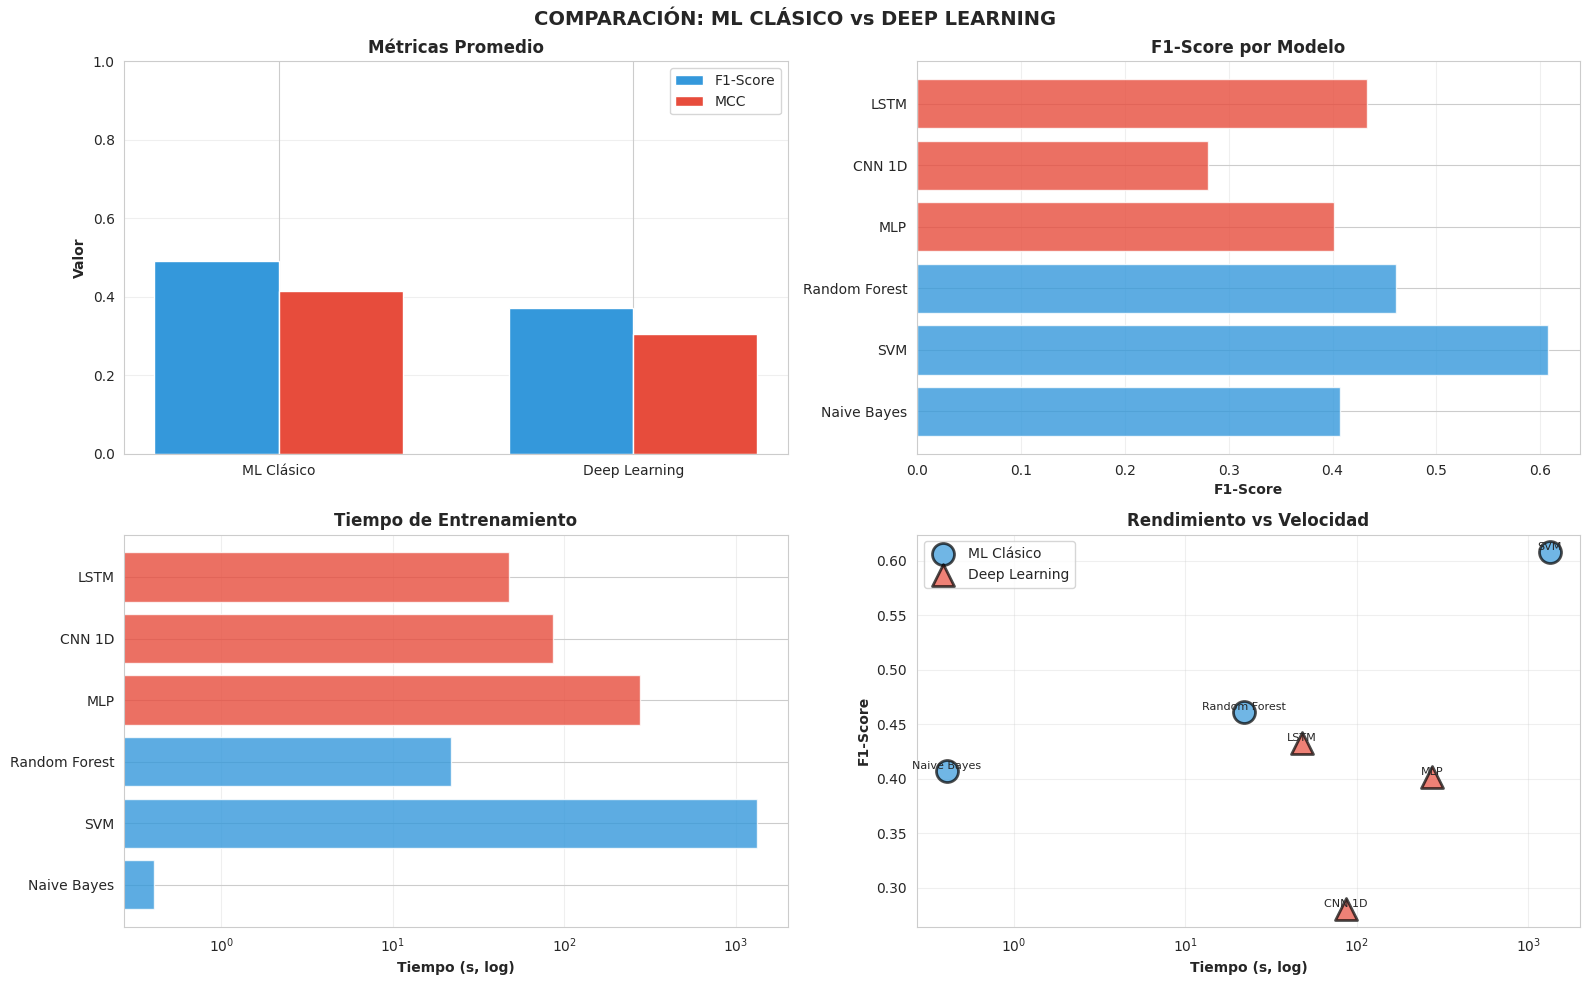


────────────────────────────────────────────────────────────────────────────────
TABLA COMPLETA
────────────────────────────────────────────────────────────────────────────────

       modelo     categoria       f1      mcc  train_time
          SVM    ML Clásico 0.607730 0.533820 1337.332086
Random Forest    ML Clásico 0.461448 0.363062   21.910026
         LSTM Deep Learning 0.432842 0.357055   47.747228
  Naive Bayes    ML Clásico 0.407179 0.349512    0.406807
          MLP Deep Learning 0.401364 0.335017  275.550521
       CNN 1D Deep Learning 0.280208 0.225035   86.091225

════════════════════════════════════════════════════════════════════════════════
CONCLUSIONES
════════════════════════════════════════════════════════════════════════════════

✓ ML Clásico mantiene competitividad (-24.5%)
✓ Tiempos similares (0.3x)

✓ MEJOR MODELO GLOBAL: SVM
  Categoría: ML Clásico
  F1-Score: 0.6077
  Tiempo: 1337.33s

✓ MODELO MÁS EFICIENTE: Naive Bayes
  Eficiencia: 0.8034

────────────────

In [ ]:
# ============================================================================
# COMPARACIÓN FINAL: MACHINE LEARNING vs DEEP LEARNING
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("═"*80)
print("COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING")
print("═"*80)

# Verificar que existen los diccionarios
if 'results_ml' not in globals():
    print("⚠️ ERROR: results_ml no existe")
    results_ml = {}

if 'results_dl' not in globals():
    print("⚠️ ERROR: results_dl no existe")
    results_dl = {}

# Verificar que no están vacíos
if len(results_ml) == 0:
    print("⚠️ WARNING: results_ml está vacío")
if len(results_dl) == 0:
    print("⚠️ WARNING: results_dl está vacío")

# Construir lista de resultados
all_results = []

# Agregar modelos ML
for model_name, metrics in results_ml.items():
    all_results.append({
        'modelo': model_name,
        'categoria': 'ML Clásico',
        'f1': metrics.get('f1', 0),
        'mcc': metrics.get('mcc', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'accuracy': metrics.get('accuracy', 0),
        'train_time': metrics.get('train_time', 0)
    })

# Agregar modelos DL
for model_name, metrics in results_dl.items():
    all_results.append({
        'modelo': model_name,
        'categoria': 'Deep Learning',
        'f1': metrics.get('f1', 0),
        'mcc': metrics.get('mcc', 0),
        'precision': metrics.get('precision', 0),
        'recall': metrics.get('recall', 0),
        'accuracy': metrics.get('accuracy', 0),
        'train_time': metrics.get('train_time', 0)
    })

# Crear DataFrame
if len(all_results) == 0:
    print("\n❌ ERROR: No hay resultados para comparar")
    print("Ejecuta primero los modelos ML y DL")
else:
    df_all = pd.DataFrame(all_results)

    # Separar por categoría
    df_ml = df_all[df_all['categoria'] == 'ML Clásico'].copy()
    df_dl = df_all[df_all['categoria'] == 'Deep Learning'].copy()

    print(f"\nModelos ML: {len(df_ml)}")
    print(f"Modelos DL: {len(df_dl)}")

    if len(df_ml) == 0 or len(df_dl) == 0:
        print("\n⚠️ No hay suficientes datos para comparar")
    else:
        # ESTADÍSTICAS
        print(f"\n{'─'*80}")
        print("ESTADÍSTICAS POR CATEGORÍA")
        print(f"{'─'*80}\n")

        for cat in ['ML Clásico', 'Deep Learning']:
            subset = df_all[df_all['categoria'] == cat]
            print(f"\n{cat}:")
            print(f"  F1-Score promedio: {subset['f1'].mean():.4f}")
            print(f"  MCC promedio:      {subset['mcc'].mean():.4f}")
            print(f"  Tiempo promedio:   {subset['train_time'].mean():.2f}s")

        # COMPARACIÓN
        print(f"\n{'─'*80}")
        print("COMPARACIÓN DE PROMEDIOS")
        print(f"{'─'*80}")

        ml_f1 = df_ml['f1'].mean()
        dl_f1 = df_dl['f1'].mean()
        mejora = ((dl_f1 - ml_f1) / ml_f1) * 100 if ml_f1 > 0 else 0

        print(f"\nF1-Score:")
        print(f"  ML Clásico:    {ml_f1:.4f}")
        print(f"  Deep Learning: {dl_f1:.4f}")
        print(f"  Diferencia:    {mejora:+.2f}%")

        ml_time = df_ml['train_time'].mean()
        dl_time = df_dl['train_time'].mean()
        ratio = dl_time / ml_time if ml_time > 0 else 0

        print(f"\nTiempo:")
        print(f"  ML Clásico:    {ml_time:.2f}s")
        print(f"  Deep Learning: {dl_time:.2f}s")
        print(f"  Ratio:         {ratio:.1f}x")

        # MEJORES MODELOS
        print(f"\n{'─'*80}")
        print("MEJORES MODELOS POR CATEGORÍA")
        print(f"{'─'*80}")

        best_ml = df_ml.loc[df_ml['f1'].idxmax()]
        best_dl = df_dl.loc[df_dl['f1'].idxmax()]

        print(f"\nMejor ML: {best_ml['modelo']}")
        print(f"  F1: {best_ml['f1']:.4f}, Tiempo: {best_ml['train_time']:.2f}s")

        print(f"\nMejor DL: {best_dl['modelo']}")
        print(f"  F1: {best_dl['f1']:.4f}, Tiempo: {best_dl['train_time']:.2f}s")

        # VISUALIZACIONES
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))

        # 1. Barras comparativas
        cats = ['ML Clásico', 'Deep Learning']
        f1_means = [ml_f1, dl_f1]
        mcc_means = [df_ml['mcc'].mean(), df_dl['mcc'].mean()]

        x = np.arange(len(cats))
        width = 0.35

        axes[0, 0].bar(x - width/2, f1_means, width, label='F1-Score', color='#3498db')
        axes[0, 0].bar(x + width/2, mcc_means, width, label='MCC', color='#e74c3c')
        axes[0, 0].set_ylabel('Valor', fontweight='bold')
        axes[0, 0].set_title('Métricas Promedio', fontsize=12, fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(cats)
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].set_ylim([0, 1])

        # 2. F1-Score individual
        colors = ['#3498db' if c == 'ML Clásico' else '#e74c3c' for c in df_all['categoria']]
        axes[0, 1].barh(df_all['modelo'], df_all['f1'], color=colors, alpha=0.8)
        axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
        axes[0, 1].set_title('F1-Score por Modelo', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='x', alpha=0.3)

        # 3. Tiempos
        axes[1, 0].barh(df_all['modelo'], df_all['train_time'], color=colors, alpha=0.8)
        axes[1, 0].set_xlabel('Tiempo (s, log)', fontweight='bold')
        axes[1, 0].set_title('Tiempo de Entrenamiento', fontsize=12, fontweight='bold')
        axes[1, 0].set_xscale('log')
        axes[1, 0].grid(axis='x', alpha=0.3)

        # 4. Scatter F1 vs Tiempo
        for cat, color, marker in [('ML Clásico', '#3498db', 'o'), ('Deep Learning', '#e74c3c', '^')]:
            subset = df_all[df_all['categoria'] == cat]
            axes[1, 1].scatter(subset['train_time'], subset['f1'],
                              c=color, s=250, alpha=0.7, label=cat,
                              marker=marker, edgecolors='black', linewidths=2)
            for _, row in subset.iterrows():
                axes[1, 1].annotate(row['modelo'],
                                   (row['train_time'], row['f1']),
                                   fontsize=8, ha='center', va='bottom')

        axes[1, 1].set_xlabel('Tiempo (s, log)', fontweight='bold')
        axes[1, 1].set_ylabel('F1-Score', fontweight='bold')
        axes[1, 1].set_title('Rendimiento vs Velocidad', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
        axes[1, 1].set_xscale('log')

        plt.suptitle('COMPARACIÓN: ML CLÁSICO vs DEEP LEARNING', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # TABLA
        print(f"\n{'─'*80}")
        print("TABLA COMPLETA")
        print(f"{'─'*80}\n")

        tabla = df_all[['modelo', 'categoria', 'f1', 'mcc', 'train_time']].sort_values('f1', ascending=False)
        print(tabla.to_string(index=False))

        # CONCLUSIONES
        print(f"\n{'═'*80}")
        print("CONCLUSIONES")
        print(f"{'═'*80}\n")

        if dl_f1 > ml_f1:
            if mejora > 5:
                print(f"✓ Deep Learning SUPERA significativamente a ML ({mejora:+.1f}%)")
            else:
                print(f"✓ Deep Learning supera ligeramente a ML ({mejora:+.1f}%)")
        else:
            print(f"✓ ML Clásico mantiene competitividad ({mejora:+.1f}%)")

        if ratio > 10:
            print(f"✓ ML es MUCHO más rápido ({ratio:.1f}x)")
        elif ratio > 2:
            print(f"✓ ML es más rápido ({ratio:.1f}x)")
        else:
            print(f"✓ Tiempos similares ({ratio:.1f}x)")

        best_overall = df_all.loc[df_all['f1'].idxmax()]
        print(f"\n✓ MEJOR MODELO GLOBAL: {best_overall['modelo']}")
        print(f"  Categoría: {best_overall['categoria']}")
        print(f"  F1-Score: {best_overall['f1']:.4f}")
        print(f"  Tiempo: {best_overall['train_time']:.2f}s")

        # Eficiencia
        df_all['eficiencia'] = df_all['f1'] / (df_all['train_time'] + 0.1)
        most_efficient = df_all.loc[df_all['eficiencia'].idxmax()]
        print(f"\n✓ MODELO MÁS EFICIENTE: {most_efficient['modelo']}")
        print(f"  Eficiencia: {most_efficient['eficiencia']:.4f}")

        # Recomendación
        print(f"\n{'─'*80}")
        print("RECOMENDACIÓN")
        print(f"{'─'*80}")

        if best_overall['categoria'] == 'Deep Learning' and mejora > 5:
            print("✅ Usar DEEP LEARNING:")
            print("   • Rendimiento superior significativo")
            print("   • Justifica inversión computacional")
        elif best_overall['categoria'] == 'ML Clásico':
            print("✅ Usar ML CLÁSICO:")
            print("   • Excelente rendimiento")
            print("   • Mucho más eficiente")
            print("   • Más rápido para producción")
        else:
            print("✅ DEPENDE DEL CONTEXTO:")
            print("   • DL si rendimiento es crítico")
            print("   • ML si velocidad es prioritaria")

        print(f"\n{'═'*80}\n")

        # EXPORTAR
        try:
            df_all.to_csv('comparacion_ml_dl.csv', index=False)
            print("✓ Exportado: comparacion_ml_dl.csv")
        except Exception as e:
            print(f"⚠️ No se pudo exportar: {e}")

print("\n✅ ANÁLISIS COMPLETADO\n")

In [ ]:
# Verifica esto en tu notebook:
print(f"Total documentos: {len(X_train)}")
print(f"Documentos por clase:")
print(pd.Series(y_train).value_counts().sort_index())

Total documentos: 23964
Documentos por clase:
0     5346
1     5346
2     5346
3     5346
4     5346
5     5346
6     5346
7     5346
8     5346
9     5346
10    5346
11    5346
12    5346
13    5346
14    5346
15    5346
16    5346
17    5346
18    5346
19    5346
20    5346
21    5346
22    5346
23    5346
24    5346
25    5346
26    5346
27    5346
28    5346
29    5346
30    5346
31    5346
32    5346
Name: count, dtype: int64


In [ ]:
# ============================================================================
# SOLUCIÓN: BALANCEAR DATASET - FILTRAR + SMOTE
# ============================================================================

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

print("="*70)
print("BALANCEANDO DATASET")
print("="*70)

# --------------------------------------------------------------------------
# PASO 1: FILTRAR CLASES CON POCOS EJEMPLOS
# --------------------------------------------------------------------------

print("\n1. FILTRANDO CLASES PEQUEÑAS...")

class_counts = Counter(y_train)
print(f"   Clases originales: {len(class_counts)}")

# FILTRAR: Mantener solo clases con >= 20 ejemplos
MIN_SAMPLES = 20
valid_classes = [cls for cls, count in class_counts.items() if count >= MIN_SAMPLES]

print(f"   Clases con >={MIN_SAMPLES} ejemplos: {len(valid_classes)}")

# Filtrar train y test
mask_train = np.isin(y_train, valid_classes)
mask_test = np.isin(y_test, valid_classes)

X_train_filtered = X_train[mask_train]
y_train_filtered = y_train[mask_train]
X_test_filtered = X_test[mask_test]
y_test_filtered = y_test[mask_test]

# Recodificar etiquetas (0, 1, 2, ... consecutivos)
le = LabelEncoder()
y_train_filtered = le.fit_transform(y_train_filtered)
y_test_filtered = le.transform(y_test_filtered)

# Actualizar label_mapping
old_to_new = {old_label: new_label for new_label, old_label in enumerate(le.classes_)}
label_mapping_new = {new_label: label_mapping.get(old_label, f"C{old_label}")
                     for old_label, new_label in old_to_new.items()}

print(f"   OK Train: {len(y_train_filtered):,} documentos")
print(f"   OK Test:  {len(y_test_filtered):,} documentos")
print(f"   OK Clases: {len(np.unique(y_train_filtered))}")

# --------------------------------------------------------------------------
# PASO 2: RE-VECTORIZAR CON DATOS FILTRADOS
# --------------------------------------------------------------------------

print("\n2. RE-VECTORIZANDO...")

# TF-IDF para ML
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)
X_train_tfidf_filtered = tfidf_vectorizer.fit_transform(X_train_filtered)
X_test_tfidf_filtered = tfidf_vectorizer.transform(X_test_filtered)

# Tokenización para DL
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_new = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer_new.fit_on_texts(X_train_filtered)

X_train_seq = tokenizer_new.texts_to_sequences(X_train_filtered)
X_test_seq = tokenizer_new.texts_to_sequences(X_test_filtered)

X_train_pad_filtered = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad_filtered = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f"   OK TF-IDF: {X_train_tfidf_filtered.shape}")
print(f"   OK Padding: {X_train_pad_filtered.shape}")

# --------------------------------------------------------------------------
# PASO 3: APLICAR SMOTE PARA BALANCEAR
# --------------------------------------------------------------------------

print("\n3. APLICANDO SMOTE...")

num_classes_new = len(np.unique(y_train_filtered))

# SMOTE para ML (TF-IDF)
smote_ml = SMOTE(random_state=SEED, k_neighbors=3)
X_train_tfidf_balanced, y_train_balanced = smote_ml.fit_resample(
    X_train_tfidf_filtered,
    y_train_filtered
)

# SMOTE para DL (Padding)
smote_dl = SMOTE(random_state=SEED, k_neighbors=3)
X_train_pad_balanced, y_train_pad_balanced = smote_dl.fit_resample(
    X_train_pad_filtered,
    y_train_filtered
)

# One-hot encoding para DL
from tensorflow.keras.utils import to_categorical
y_train_cat_balanced = to_categorical(y_train_pad_balanced, num_classes_new)
y_test_cat_new = to_categorical(y_test_filtered, num_classes_new)

print(f"   OK Antes SMOTE: {len(y_train_filtered):,} ejemplos")
print(f"   OK Despues SMOTE: {len(y_train_balanced):,} ejemplos")

print(f"\n   Distribucion balanceada:")
dist = pd.Series(y_train_balanced).value_counts().sort_index()
print(f"   Min: {dist.min()}, Max: {dist.max()}, Media: {dist.mean():.0f}")

# --------------------------------------------------------------------------
# PASO 4: ACTUALIZAR VARIABLES GLOBALES
# --------------------------------------------------------------------------

print("\n4. ACTUALIZANDO VARIABLES...")

# Para ML
X_train_tfidf = X_train_tfidf_balanced
y_train = y_train_balanced
X_test_tfidf = X_test_tfidf_filtered
y_test = y_test_filtered

# Para DL
X_train_pad = X_train_pad_balanced
y_train_cat = y_train_cat_balanced
X_test_pad = X_test_pad_filtered
y_test_cat = y_test_cat_new

# Actualizar otros
num_classes = num_classes_new
label_mapping = label_mapping_new
tokenizer = tokenizer_new

print(f"   OK num_classes: {num_classes}")
print(f"   OK X_train_tfidf: {X_train_tfidf.shape}")
print(f"   OK X_train_pad: {X_train_pad.shape}")
print(f"   OK y_train_cat: {y_train_cat.shape}")

# --------------------------------------------------------------------------
# RESUMEN
# --------------------------------------------------------------------------

print(f"\n{'='*70}")
print("RESUMEN")
print(f"{'='*70}")
print(f"Clases: {len(class_counts)} a {num_classes}")
print(f"Train: {len(y_train_filtered):,} a {len(y_train_balanced):,}")
print(f"Test: {len(y_test_filtered):,}")
print(f"\nOK DATASET BALANCEADO")
print(f"OK Ahora RE-ENTRENA TODOS LOS MODELOS (ML y DL)")
print(f"{'='*70}\n")

# Verificación
print("Verificacion rapida:")
print(f"  results_ml existe: {'results_ml' in globals()}")
print(f"  results_dl existe: {'results_dl' in globals()}")
print(f"\nIMPORTANTE: Debes re-ejecutar TODAS las celdas de modelos")

BALANCEANDO DATASET

1. FILTRANDO CLASES PEQUEÑAS...
   Clases originales: 119
   Clases con >=20 ejemplos: 33
   OK Train: 23,413 documentos
   OK Test:  5,855 documentos
   OK Clases: 33

2. RE-VECTORIZANDO...
   OK TF-IDF: (23413, 5000)
   OK Padding: (23413, 200)

3. APLICANDO SMOTE...
   OK Antes SMOTE: 23,413 ejemplos
   OK Despues SMOTE: 176,418 ejemplos

   Distribucion balanceada:
   Min: 5346, Max: 5346, Media: 5346

4. ACTUALIZANDO VARIABLES...
   OK num_classes: 33
   OK X_train_tfidf: (176418, 5000)
   OK X_train_pad: (176418, 200)
   OK y_train_cat: (176418, 33)

RESUMEN
Clases: 119 a 33
Train: 23,413 a 176,418
Test: 5,855

OK DATASET BALANCEADO
OK Ahora RE-ENTRENA TODOS LOS MODELOS (ML y DL)

Verificacion rapida:
  results_ml existe: False
  results_dl existe: False

IMPORTANTE: Debes re-ejecutar TODAS las celdas de modelos
